# Yield Optimization - Solution ESG pour ClientCo

**Objectif** : Utiliser l'IA pour optimiser les achats de céréales et réduire l'impact environnemental tout en améliorant la résilience agricole.

**Problème business et ESG** :
- Rendement instable à cause de sécheresses, manque de précipitations, vagues de chaleur
- Conséquences ESG : plus d'irrigation → plus d'eau, pertes de récolte → gaspillage, sourcing d'urgence → transport → Scope 3 élevé
- **Solution** : Acheter dans les zones où le rendement sera stable et résilient


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

raw_data_path = Path("Raw data")
barley_df = pd.read_csv(raw_data_path / "barley_yield_from_1982.csv", sep=';')
climate_df = pd.read_parquet(raw_data_path / "climate_data_from_1982.parquet")
eau_df = pd.read_csv(raw_data_path / "eau.csv")
sols_df = pd.read_csv(raw_data_path / "sols.csv", sep=';', encoding="latin1")

barley_df = barley_df.drop(columns=['Unnamed: 0'], errors='ignore')

print(f"Donnees chargees: Barley {barley_df.shape}, Climate {climate_df.shape}")

Donnees chargees: Barley (3583, 5), Climate (13540116, 7)


In [2]:
sols_df = sols_df.iloc[:, :3]
sols_df.columns = ['code_dept', 'soil_type', 'ph_mean']
sols_df['ph_mean'] = sols_df['ph_mean'].astype(str).str.replace(',', '.').astype(float)

dept_mapping = climate_df[['code_dep', 'nom_dep']].drop_duplicates().set_index('code_dep')['nom_dep'].to_dict()
sols_df['department'] = sols_df['code_dept'].map(dept_mapping)

sols_df = sols_df.dropna(subset=['department']).drop_duplicates(subset=['department'], keep='first')
soil_info = sols_df.set_index('department')[['soil_type', 'ph_mean']].to_dict('index')


## ÉTAPE 1 : Lier Climat → Yield (Modèle prédictif)


In [3]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

PRECIP_THRESHOLD_M_PER_DAY = 0.00005

ml_data = []
ml_data_futur = []

temp_data_hist = climate_df[(climate_df['metric'] == 'near_surface_air_temperature') & (climate_df['scenario'] == 'historical')].copy()
temp_data_hist['temp_celsius'] = temp_data_hist['value'] - 273.15
precip_data_hist = climate_df[(climate_df['metric'] == 'precipitation') & (climate_df['scenario'] == 'historical')].copy()

temp_data_futur = climate_df[(climate_df['metric'] == 'near_surface_air_temperature') & (climate_df['scenario'] == 'ssp1_2_6')].copy()
temp_data_futur['temp_celsius'] = temp_data_futur['value'] - 273.15
precip_data_futur = climate_df[(climate_df['metric'] == 'precipitation') & (climate_df['scenario'] == 'ssp1_2_6')].copy()

# Diagnostic: vérifier quelles années ont des données
years_temp_futur = sorted(temp_data_futur['year'].unique()) if len(temp_data_futur) > 0 else []
years_precip_futur = sorted(precip_data_futur['year'].unique()) if len(precip_data_futur) > 0 else []
depts_temp_futur = set(temp_data_futur['nom_dep'].unique()) if len(temp_data_futur) > 0 else set()
depts_precip_futur = set(precip_data_futur['nom_dep'].unique()) if len(precip_data_futur) > 0 else set()

print(f"=== DIAGNOSTIC DONNEES FUTURES ===")
print(f"Annees avec donnees temperature futures: {len(years_temp_futur)} ({min(years_temp_futur) if years_temp_futur else 'N/A'}-{max(years_temp_futur) if years_temp_futur else 'N/A'})")
print(f"Annees avec donnees precipitations futures: {len(years_precip_futur)} ({min(years_precip_futur) if years_precip_futur else 'N/A'}-{max(years_precip_futur) if years_precip_futur else 'N/A'})")
print(f"Departements avec donnees temp futures: {len(depts_temp_futur)}")
print(f"Departements avec donnees precip futures: {len(depts_precip_futur)}")

missing_precip_depts = depts_temp_futur - depts_precip_futur
if missing_precip_depts:
    print(f"\n{len(missing_precip_depts)} departements avec temp mais SANS precip futures:")
    for dept in sorted(list(missing_precip_depts))[:10]:
        print(f"   - {dept}")
    if len(missing_precip_depts) > 10:
        print(f"   ... et {len(missing_precip_depts) - 10} autres")


temp_data_combined = pd.concat([temp_data_hist, temp_data_futur])
precip_data_combined = pd.concat([precip_data_hist, precip_data_futur])

temp_data_combined = temp_data_combined.set_index(['nom_dep', 'year'])
precip_data_combined = precip_data_combined.set_index(['nom_dep', 'year'])

total_depts = len(barley_df['department'].unique())
dept_count = 0

for dept in barley_df['department'].unique():
    dept_count += 1
    if dept_count % 10 == 0:
        print(f"Traitement: {dept_count}/{total_depts} departements")
    dept_barley = barley_df[barley_df['department'] == dept].copy()
    
    for _, row in dept_barley.iterrows():
        year = row['year']
        dept_name = row['department']
       
        try:
            temp_year = temp_data_combined.loc[(dept_name, year)].reset_index()
            precip_year = precip_data_combined.loc[(dept_name, year)].reset_index()
            if isinstance(temp_year, pd.Series):
                temp_year = temp_year.to_frame().T.reset_index()
            if isinstance(precip_year, pd.Series):
                precip_year = precip_year.to_frame().T.reset_index()
        except KeyError:
            continue
        
        if len(temp_year) > 0 and len(precip_year) > 0:
            precip_year_copy = precip_year.copy()
            precip_year_copy['date'] = pd.to_datetime(precip_year_copy['time'])
            precip_year_copy['month'] = precip_year_copy['date'].dt.month
            precip_year_copy['is_rainy'] = (precip_year_copy['value'] > PRECIP_THRESHOLD_M_PER_DAY).astype(int)
            days_rainy_per_month = precip_year_copy.groupby('month')['is_rainy'].sum()
            
            days_rainy_by_month = {month: 0 for month in range(1, 13)}
            for month, count in days_rainy_per_month.items():
                days_rainy_by_month[int(month)] = int(count)
            
            features = {
                'department': dept_name,
                'year': year,
                'precip_total': precip_year['value'].sum(),
                'precip_mean': precip_year['value'].mean(),
                'precip_std': precip_year['value'].std(),
                'precip_max': precip_year['value'].max(),
                'precip_min': precip_year['value'].min(),
                'days_dry': (precip_year['value'] < PRECIP_THRESHOLD_M_PER_DAY).sum(),
                'days_rainy_total': precip_year_copy['is_rainy'].sum(),
                'days_rainy_mean_monthly': days_rainy_per_month.mean() if len(days_rainy_per_month) > 0 else 0,
                'days_rainy_jan': days_rainy_by_month[1],
                'days_rainy_feb': days_rainy_by_month[2],
                'days_rainy_mar': days_rainy_by_month[3],
                'days_rainy_apr': days_rainy_by_month[4],
                'days_rainy_may': days_rainy_by_month[5],
                'days_rainy_jun': days_rainy_by_month[6],
                'days_rainy_jul': days_rainy_by_month[7],
                'days_rainy_aug': days_rainy_by_month[8],
                'days_rainy_sep': days_rainy_by_month[9],
                'days_rainy_oct': days_rainy_by_month[10],
                'days_rainy_nov': days_rainy_by_month[11],
                'days_rainy_dec': days_rainy_by_month[12],
                'temp_mean': temp_year['temp_celsius'].mean(),
                'temp_max': temp_year['temp_celsius'].max(),
                'temp_min': temp_year['temp_celsius'].min(),
                'temp_range': temp_year['temp_celsius'].max() - temp_year['temp_celsius'].min(),
                'days_hot': (temp_year['temp_celsius'] > 20).sum(),
                'days_very_hot': (temp_year['temp_celsius'] > 25).sum(),
            }
            
            if dept_name in soil_info:
                features['soil_type'] = soil_info[dept_name]['soil_type']
                features['ph_mean'] = soil_info[dept_name]['ph_mean']
            else:
                features['soil_type'] = 'Unknown'
                features['ph_mean'] = sols_df['ph_mean'].median()
            
            features['yield'] = row['yield']
            ml_data.append(features)

print("Creation dataset predictions futures...")
years_to_process = sorted(years_temp_futur) if years_temp_futur else range(2019, 2051)
print(f"Utilisation de {len(years_to_process)} annees avec donnees temperature")

neighboring_depts = {
    'Calvados': ['Manche', 'Orne', 'Eure'],
    'Deux_Sevres': ['Vienne', 'Charente', 'Charente_Maritime', 'Vendee'],
    'Essonne': ['Seine_et_Marne', 'Val_d_Oise', 'Hauts_de_Seine', 'Eure_et_Loir'],
    'Eure': ['Seine_Maritime', 'Oise', 'Val_d_Oise', 'Calvados', 'Orne'],
    'Rhone': ['Ain', 'Isere', 'Loire', 'Saone_et_Loire'],
    'Tarn_et_Garonne': ['Lot', 'Aveyron', 'Tarn', 'Gers', 'Haute_Garonne', 'Lot_et_Garonne'],
    'Territoire_de_Belfort': ['Vosges', 'Haute_Saone', 'Doubs', 'Haut_Rhin'],
    'Vaucluse': ['Drome', 'Ardeche', 'Gard', 'Bouches_du_Rhone', 'Alpes_de_Haute_Provence'],
}

def get_neighbor_precip_stats(dept_name, year, precip_data_combined, neighboring_depts, depts_with_precip_futur):
    """Obtenir les statistiques de précipitations des départements voisins"""
    if dept_name not in neighboring_depts:
        return None
    
    neighbors = neighboring_depts[dept_name]
    neighbor_precips = []
    
    for neighbor in neighbors:
        if neighbor in depts_with_precip_futur:
            try:
                neighbor_precip = precip_data_combined.loc[(neighbor, year)].reset_index()
                if isinstance(neighbor_precip, pd.Series):
                    neighbor_precip = neighbor_precip.to_frame().T.reset_index()
                if len(neighbor_precip) > 0:
                    neighbor_precips.append({
                        'mean': neighbor_precip['value'].mean(),
                        'std': neighbor_precip['value'].std(),
                        'max': neighbor_precip['value'].max(),
                        'min': neighbor_precip['value'].min(),
                        'total': neighbor_precip['value'].sum(),
                        'days_dry': (neighbor_precip['value'] < PRECIP_THRESHOLD_M_PER_DAY).sum(),
                        'days_rainy': (neighbor_precip['value'] > PRECIP_THRESHOLD_M_PER_DAY).sum(),
                    })
            except KeyError:
                continue
    
    if len(neighbor_precips) >= 2:  # Au moins 2 voisins avec données
        # Calculer la moyenne des statistiques des voisins
        return {
            'mean': np.mean([n['mean'] for n in neighbor_precips]),
            'std': np.mean([n['std'] for n in neighbor_precips]),
            'max': np.mean([n['max'] for n in neighbor_precips]),
            'min': np.mean([n['min'] for n in neighbor_precips]),
            'total': np.mean([n['total'] for n in neighbor_precips]),
            'days_dry': int(np.mean([n['days_dry'] for n in neighbor_precips])),
            'days_rainy': int(np.mean([n['days_rainy'] for n in neighbor_precips])),
        }
    
    return None

global_precip_mean = precip_data_hist['value'].mean() if len(precip_data_hist) > 0 else 0.001
global_precip_std = precip_data_hist['value'].std() if len(precip_data_hist) > 0 else 0.0005
global_precip_max = precip_data_hist['value'].max() if len(precip_data_hist) > 0 else 0.01
global_precip_min = precip_data_hist['value'].min() if len(precip_data_hist) > 0 else 0.0

total_iterations = len(years_to_process) * len(barley_df['department'].unique())
iteration_count = 0

for year in years_to_process:
    if year % 5 == 0:
        print(f"  Traitement annee {year}...")
    depts_to_process = depts_temp_futur.intersection(set(barley_df['department'].unique())) if depts_temp_futur else barley_df['department'].unique()
    
    for dept_name in depts_to_process:
        iteration_count += 1
        try:
            temp_year = temp_data_combined.loc[(dept_name, year)].reset_index()
            if isinstance(temp_year, pd.Series):
                temp_year = temp_year.to_frame().T.reset_index()
        except KeyError:
            continue
        
        if len(temp_year) > 0:
            try:
                precip_year = precip_data_combined.loc[(dept_name, year)].reset_index()
                if isinstance(precip_year, pd.Series):
                    precip_year = precip_year.to_frame().T.reset_index()
                has_precip = len(precip_year) > 0
            except KeyError:
                has_precip = False
                precip_year = None
            
            if has_precip:
                precip_year_copy = precip_year.copy()
                precip_year_copy['date'] = pd.to_datetime(precip_year_copy['time'])
                precip_year_copy['month'] = precip_year_copy['date'].dt.month
                precip_year_copy['is_rainy'] = (precip_year_copy['value'] > PRECIP_THRESHOLD_M_PER_DAY).astype(int)
                days_rainy_per_month = precip_year_copy.groupby('month')['is_rainy'].sum()
                
                days_rainy_by_month = {month: 0 for month in range(1, 13)}
                for month, count in days_rainy_per_month.items():
                    days_rainy_by_month[int(month)] = int(count)
                
                precip_total = precip_year['value'].sum()
                precip_mean = precip_year['value'].mean()
                precip_std = precip_year['value'].std()
                precip_max = precip_year['value'].max()
                precip_min = precip_year['value'].min()
                days_dry = (precip_year['value'] < PRECIP_THRESHOLD_M_PER_DAY).sum()
                days_rainy_total = precip_year_copy['is_rainy'].sum()
                days_rainy_mean_monthly = days_rainy_per_month.mean() if len(days_rainy_per_month) > 0 else 0
            else:
                neighbor_stats = get_neighbor_precip_stats(dept_name, year, precip_data_combined, neighboring_depts, depts_precip_futur)
                
                if neighbor_stats:
                    precip_mean = neighbor_stats['mean']
                    precip_std = neighbor_stats['std']
                    precip_max = neighbor_stats['max']
                    precip_min = neighbor_stats['min']
                    precip_total = neighbor_stats['total']
                    days_dry = neighbor_stats['days_dry']
                    days_rainy_total = neighbor_stats['days_rainy']
                    days_rainy_mean_monthly = days_rainy_total / 12  
                    days_per_month = days_rainy_total / 12
                    days_rainy_by_month = {month: int(days_per_month) for month in range(1, 13)}
                    total_assigned = sum(days_rainy_by_month.values())
                    if total_assigned != days_rainy_total:
                        diff = days_rainy_total - total_assigned
                        for i in range(1, min(abs(diff) + 1, 13)):
                            if diff > 0:
                                days_rainy_by_month[i] += 1
                            else:
                                days_rainy_by_month[i] = max(0, days_rainy_by_month[i] - 1)
                else:
                    try:
                        dept_precip_hist = precip_data_combined.loc[(dept_name, slice(1982, 2014))].reset_index()
                        if isinstance(dept_precip_hist, pd.Series):
                            dept_precip_hist = dept_precip_hist.to_frame().T.reset_index()
                        if len(dept_precip_hist) > 0:
                            precip_mean = dept_precip_hist['value'].mean()
                            precip_std = dept_precip_hist['value'].std()
                            precip_max = dept_precip_hist['value'].max()
                            precip_min = dept_precip_hist['value'].min()
                            precip_total = precip_mean * 365
                        else:
                            precip_mean = global_precip_mean
                            precip_std = global_precip_std
                            precip_max = global_precip_max
                            precip_min = global_precip_min
                            precip_total = precip_mean * 365
                    except (KeyError, ValueError):
                        precip_mean = global_precip_mean
                        precip_std = global_precip_std
                        precip_max = global_precip_max
                        precip_min = global_precip_min
                        precip_total = precip_mean * 365
                    
                    days_rainy_by_month = {month: 0 for month in range(1, 13)}
                    days_dry = 200 
                    days_rainy_total = 120
                    days_rainy_mean_monthly = 10 
            
            features_futur = {
                'department': dept_name,
                'year': year,
                'precip_total': precip_total,
                'precip_mean': precip_mean,
                'precip_std': precip_std,
                'precip_max': precip_max,
                'precip_min': precip_min,
                'days_dry': days_dry,
                'days_rainy_total': days_rainy_total,
                'days_rainy_mean_monthly': days_rainy_mean_monthly,
                'days_rainy_jan': days_rainy_by_month[1],
                'days_rainy_feb': days_rainy_by_month[2],
                'days_rainy_mar': days_rainy_by_month[3],
                'days_rainy_apr': days_rainy_by_month[4],
                'days_rainy_may': days_rainy_by_month[5],
                'days_rainy_jun': days_rainy_by_month[6],
                'days_rainy_jul': days_rainy_by_month[7],
                'days_rainy_aug': days_rainy_by_month[8],
                'days_rainy_sep': days_rainy_by_month[9],
                'days_rainy_oct': days_rainy_by_month[10],
                'days_rainy_nov': days_rainy_by_month[11],
                'days_rainy_dec': days_rainy_by_month[12],
                'temp_mean': temp_year['temp_celsius'].mean(),
                'temp_max': temp_year['temp_celsius'].max(),
                'temp_min': temp_year['temp_celsius'].min(),
                'temp_range': temp_year['temp_celsius'].max() - temp_year['temp_celsius'].min(),
                'days_hot': (temp_year['temp_celsius'] > 20).sum(),
                'days_very_hot': (temp_year['temp_celsius'] > 25).sum(),
            }
            
            if dept_name in soil_info:
                features_futur['soil_type'] = soil_info[dept_name]['soil_type']
                features_futur['ph_mean'] = soil_info[dept_name]['ph_mean']
            else:
                features_futur['soil_type'] = 'Unknown'
                features_futur['ph_mean'] = sols_df['ph_mean'].median()
            
            features_futur['yield'] = np.nan
            ml_data_futur.append(features_futur)

ml_df = pd.DataFrame(ml_data).dropna()
ml_df_futur = pd.DataFrame(ml_data_futur)

print(f"\n=== DIAGNOSTIC DEPARTEMENTS ===")
print(f"Dataset cree: {len(ml_df)} observations avec yield, {len(ml_df_futur)} observations futures")

all_barley_depts = set(barley_df['department'].unique())
depts_in_ml_df = set(ml_df['department'].unique()) if len(ml_df) > 0 else set()
depts_in_ml_df_futur = set(ml_df_futur['department'].unique()) if len(ml_df_futur) > 0 else set()

print(f"\nDepartements dans barley_df: {len(all_barley_depts)}")
print(f"Departements dans ml_df: {len(depts_in_ml_df)}")
print(f"Departements dans ml_df_futur: {len(depts_in_ml_df_futur)}")

missing_in_ml_df = all_barley_depts - depts_in_ml_df
missing_in_ml_df_futur = all_barley_depts - depts_in_ml_df_futur

if missing_in_ml_df:
    print(f"\n⚠️  Departements dans barley_df mais PAS dans ml_df ({len(missing_in_ml_df)}):")
    for dept in sorted(missing_in_ml_df):
        print(f"   - {dept}")

if missing_in_ml_df_futur:
    print(f"\n⚠️  Departements dans barley_df mais PAS dans ml_df_futur ({len(missing_in_ml_df_futur)}):")
    temp_data_reset = temp_data_combined.reset_index()
    precip_data_reset = precip_data_combined.reset_index()
    for dept in sorted(missing_in_ml_df_futur):
        temp_check = temp_data_reset[temp_data_reset['nom_dep'] == dept]
        precip_check = precip_data_reset[precip_data_reset['nom_dep'] == dept]
        years_with_temp = set(temp_check['year'].unique()) if len(temp_check) > 0 else set()
        years_with_precip = set(precip_check['year'].unique()) if len(precip_check) > 0 else set()
        years_futur = set(range(2019, 2051))
        years_with_both = years_with_temp.intersection(years_with_precip).intersection(years_futur)
        
        print(f"   - {dept}: temp_years={len(years_with_temp)}, precip_years={len(years_with_precip)}, futur_years_with_both={len(years_with_both)}")

print(f"\n✅ Departements avec donnees futures: {len(depts_in_ml_df_futur)}")
print("="*90)


=== DIAGNOSTIC DONNEES FUTURES ===
Annees avec donnees temperature futures: 36 (2015-2050)
Annees avec donnees precipitations futures: 36 (2015-2050)
Departements avec donnees temp futures: 89
Departements avec donnees precip futures: 89
Traitement: 10/97 departements
Traitement: 20/97 departements
Traitement: 30/97 departements
Traitement: 40/97 departements
Traitement: 50/97 departements
Traitement: 60/97 departements
Traitement: 70/97 departements
Traitement: 80/97 departements
Traitement: 90/97 departements
Creation dataset predictions futures...
Utilisation de 36 annees avec donnees temperature
  Traitement annee 2015...
  Traitement annee 2020...
  Traitement annee 2025...
  Traitement annee 2030...
  Traitement annee 2035...
  Traitement annee 2040...
  Traitement annee 2045...
  Traitement annee 2050...

=== DIAGNOSTIC DEPARTEMENTS ===
Dataset cree: 3168 observations avec yield, 3204 observations futures

Departements dans barley_df: 97
Departements dans ml_df: 89
Departements 


📊 Types de sols encodés: ['soil_Argile', 'soil_Basalte', 'soil_Caillouteux', 'soil_Calcaire', 'soil_Granite', 'soil_Limon', 'soil_Sable', 'soil_Schiste']

✅ Total de 26 features (climatiques + sol):
   - 26 features climatiques
   - 1 feature pH
   - 8 features type de sol (one-hot)

Valeurs manquantes dans les features:
Series([], dtype: int64)
=== PERFORMANCE DU MODELE (Gradient Boosting) ===
R²: 0.565
RMSE: 0.935 t/ha

=== TOP 15 FEATURES ===
           feature  importance
21        temp_max    0.180189
4       precip_min    0.097329
20       temp_mean    0.074538
2       precip_std    0.065246
19  days_rainy_dec    0.059792
12  days_rainy_may    0.037253
8   days_rainy_jan    0.036885
22        temp_min    0.036253
17  days_rainy_oct    0.035971
23      temp_range    0.033948
3       precip_max    0.033356
24        days_hot    0.033057
15  days_rainy_aug    0.028692
14  days_rainy_jul    0.028304
16  days_rainy_sep    0.027037


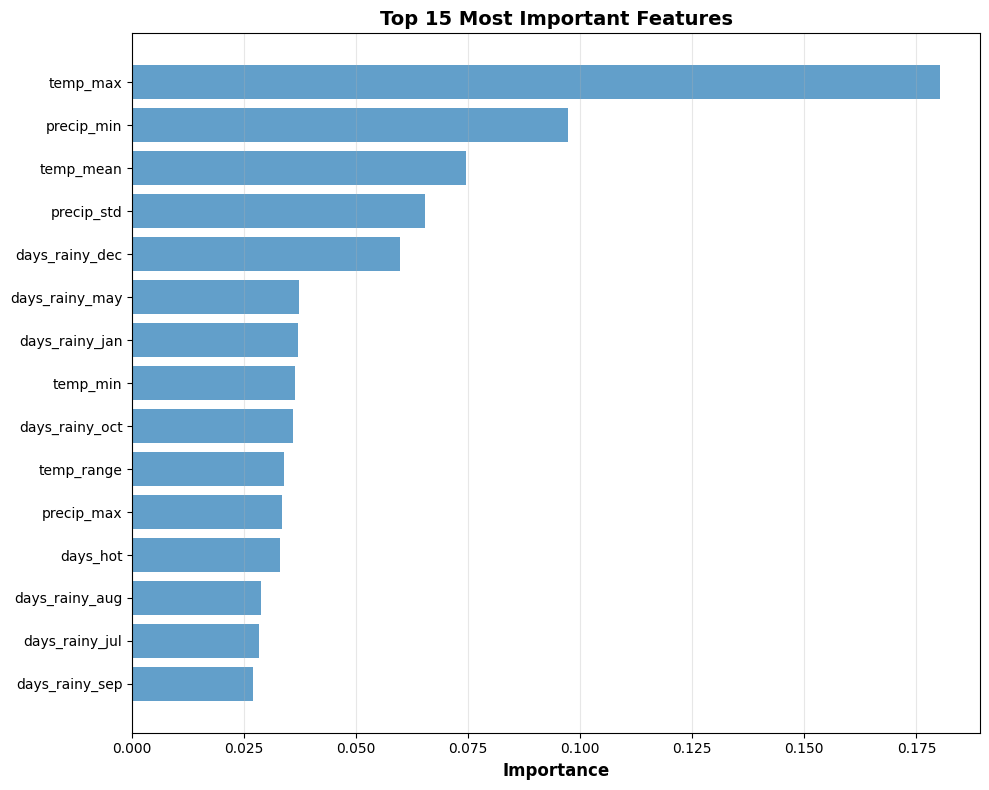

In [4]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor

climate_feature_cols = ['precip_total', 'precip_mean', 'precip_std', 'precip_max', 'precip_min', 
                        'days_dry', 'days_rainy_total', 'days_rainy_mean_monthly',
                        'days_rainy_jan', 'days_rainy_feb', 'days_rainy_mar', 'days_rainy_apr',
                        'days_rainy_may', 'days_rainy_jun', 'days_rainy_jul', 'days_rainy_aug',
                        'days_rainy_sep', 'days_rainy_oct', 'days_rainy_nov', 'days_rainy_dec',
                        'temp_mean', 'temp_max', 'temp_min', 'temp_range', 'days_hot', 'days_very_hot']

soil_dummies = pd.get_dummies(ml_df['soil_type'], prefix='soil')
print(f"\n📊 Types de sols encodés: {soil_dummies.columns.tolist()}")

X_climate = ml_df[climate_feature_cols].copy()
X_soil_ph = ml_df[['ph_mean']].copy()
X_soil_type = soil_dummies.copy()

X = X_climate
#X = pd.concat([X_climate, X_soil_ph, X_soil_type], axis=1)
y = ml_df['yield'].copy()

feature_cols = list(X.columns)
print(f"\n✅ Total de {len(feature_cols)} features (climatiques + sol):")
print(f"   - {len(climate_feature_cols)} features climatiques")
print(f"   - 1 feature pH")
print(f"   - {len(soil_dummies.columns)} features type de sol (one-hot)")

print(f"\nValeurs manquantes dans les features:")
missing = X.isna().sum()
print(missing[missing > 0])

for col in feature_cols:
    if X[col].isna().sum() > 0:
        if col.startswith('soil_'): 
            X[col].fillna(0, inplace=True)
        else:  
            X[col].fillna(X[col].median(), inplace=True)
        print(f"   {col}: {X[col].isna().sum()} NaN remplacés")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False, random_state=42
)

rf_model = GradientBoostingRegressor(
    n_estimators=200,    
    learning_rate=0.05,     
    max_depth=300,            
    subsample=0.8,          
    random_state=42
)

rf_model.fit(X_train, y_train)

y_pred_test = rf_model.predict(X_test)
r2_test = r2_score(y_test, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

print("=== PERFORMANCE DU MODELE (Gradient Boosting) ===")
print(f"R²: {r2_test:.3f}")
print(f"RMSE: {rmse_test:.3f} t/ha")

feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n=== TOP 15 FEATURES ===")
print(feature_importance.head(15))

top_15 = feature_importance.head(15)
fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(range(len(top_15)), top_15['importance'], alpha=0.7)
ax.set_yticks(range(len(top_15)))
ax.set_yticklabels(top_15['feature'], fontsize=10)
ax.set_xlabel('Importance', fontsize=12, fontweight='bold')
ax.set_title('Top 15 Most Important Features', fontsize=14, fontweight='bold')
ax.invert_yaxis()
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

# Prédiction sur le scénario futur (inchangé, on réutilise rf_model)
if len(ml_df_futur) > 0:
    soil_dummies_futur = pd.get_dummies(ml_df_futur['soil_type'], prefix='soil')
    for col in soil_dummies.columns:
        if col not in soil_dummies_futur.columns:
            soil_dummies_futur[col] = 0
    soil_dummies_futur = soil_dummies_futur[soil_dummies.columns]
    
    X_futur_climate = ml_df_futur[climate_feature_cols].copy()
    X_futur_soil_ph = ml_df_futur[['ph_mean']].copy()
    X_futur = pd.concat([X_futur_climate, X_futur_soil_ph, soil_dummies_futur], axis=1)
    X_futur = X_futur[feature_cols]
    
    for col in feature_cols:
        if X_futur[col].isna().sum() > 0:
            if col.startswith('soil_'):
                X_futur[col].fillna(0, inplace=True)
            else:
                X_futur[col].fillna(X_train[col].median(), inplace=True)
    
    y_pred_futur = rf_model.predict(X_futur)
    ml_df_futur['yield_predicted'] = y_pred_futur


## ÉTAPE 2 : Analyse des outputs des departements avec meilleurs rendements 

Top 10 départements avec meilleurs yields prédits:
            department  yield_predicted_mean
6             Ardennes              6.150878
1                Aisne              6.101144
29           Finistere              6.036597
36         Haute_Marne              5.949630
60  Meurthe_et_Moselle              5.948534
65                Nord              5.941305
68       Pas_de_Calais              5.927240
63             Moselle              5.924149
61               Meuse              5.922561
13            Calvados              5.904974


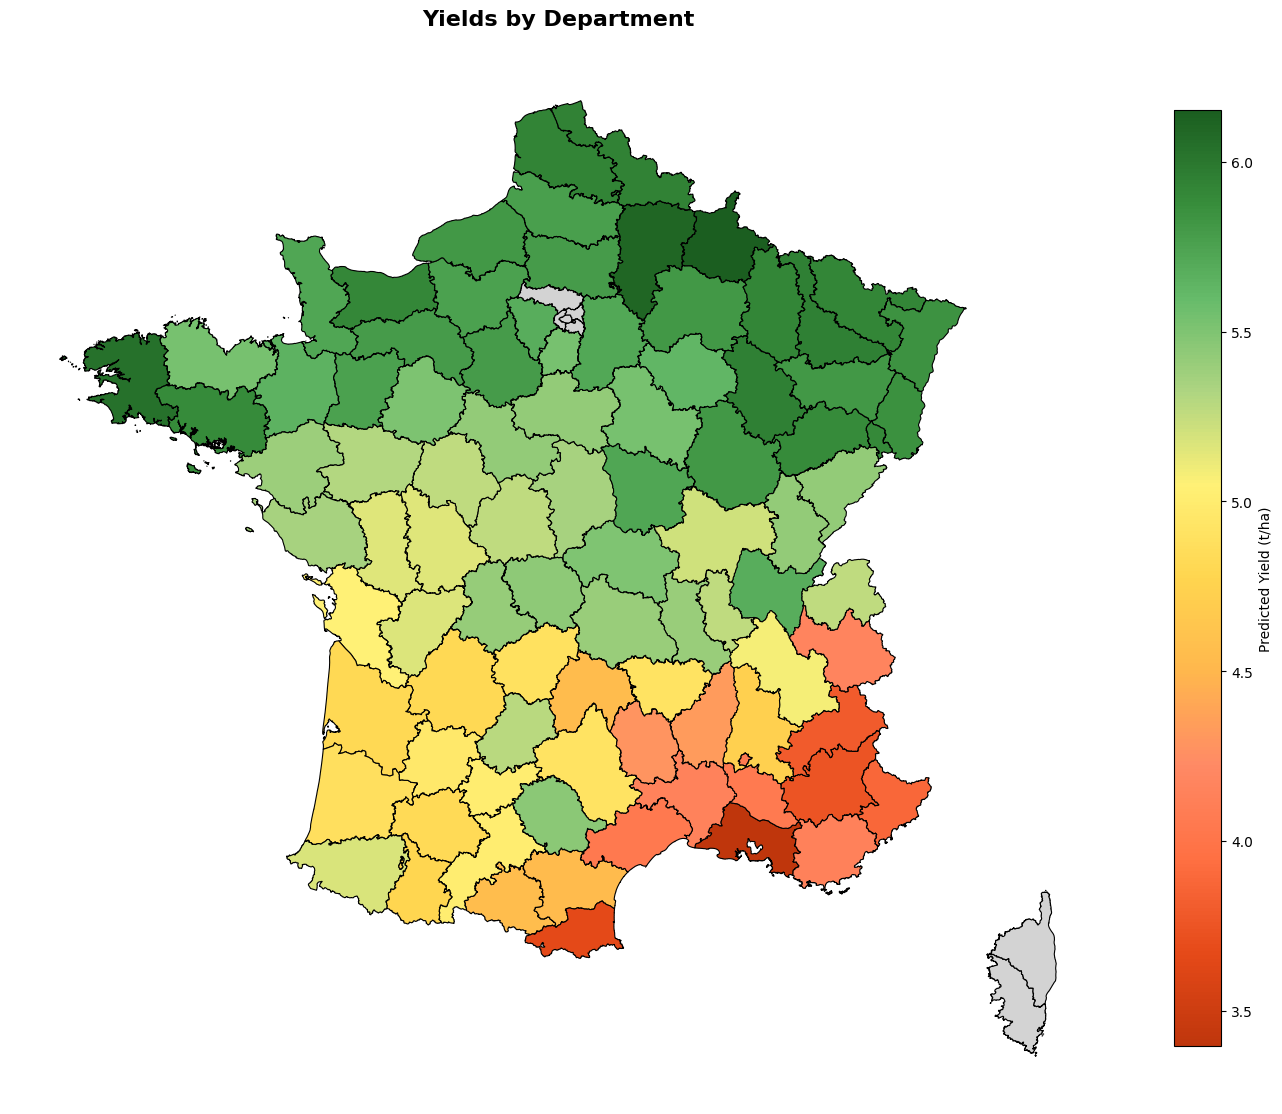

In [5]:
yield_by_dept = ml_df_futur.groupby('department')['yield_predicted'].mean().reset_index()
yield_by_dept.columns = ['department', 'yield_predicted_mean']

print(f"Top 10 départements avec meilleurs yields prédits:")
print(yield_by_dept.nlargest(10, 'yield_predicted_mean'))

try:
    import geopandas as gpd
    from matplotlib.colors import LinearSegmentedColormap
    import ssl
    import urllib.request
    import tempfile
    import json
    
    def normalize_name(name):
        name = str(name).lower().replace('-', '_').replace(' ', '_')
        replacements = {'é': 'e', 'è': 'e', 'ê': 'e', 'à': 'a', 'î': 'i', 'ô': 'o', 'ù': 'u', 'ç': 'c', "'": '', '"': ''}
        for old, new in replacements.items():
            name = name.replace(old, new)
        return name
  
    url = 'https://raw.githubusercontent.com/gregoiredavid/france-geojson/master/departements.geojson'
    context = ssl._create_unverified_context()
    with urllib.request.urlopen(url, context=context) as response:
        data = json.loads(response.read())
    with tempfile.NamedTemporaryFile(mode='w', suffix='.geojson', delete=False) as tmp_file:
        json.dump(data, tmp_file)
        tmp_path = tmp_file.name
    france_geo = gpd.read_file(tmp_path)
    import os
    os.unlink(tmp_path)

    if 'code' in france_geo.columns:
        france_geo = france_geo[~france_geo['code'].astype(str).str.startswith('97')]
    
    france_geo['department_norm'] = france_geo['nom'].apply(normalize_name)
    yield_map = yield_by_dept.copy()
    yield_map['department_norm'] = yield_map['department'].apply(normalize_name)

    mapping = {'cote_d_or': 'cote_dor', 'cotes_d_armor': 'cotes_darmor'}
    for old, new in mapping.items():
        yield_map.loc[yield_map['department_norm'] == old, 'department_norm'] = new
    
    france_yield_map = france_geo.merge(yield_map[['department_norm', 'yield_predicted_mean']], 
                                         on='department_norm', how='left')
    
    fig, ax = plt.subplots(figsize=(14, 12))
    colors = ['#BF360C', '#E64A19', '#FF7043', '#FF8A65', '#FFB74D', '#FFD54F', 
              '#FFF176', '#AED581', '#66BB6A', '#388E3C', '#1B5E20']
    cmap = LinearSegmentedColormap.from_list('yield', colors, N=256)
    
    france_yield_map.plot(column='yield_predicted_mean', cmap=cmap, linewidth=0.8, 
                          edgecolor='black', legend=True, ax=ax,
                          missing_kwds={'color': 'lightgrey', 'edgecolor': 'black'},
                          legend_kwds={'label': 'Predicted Yield (t/ha)', 'shrink': 0.8})
    
    ax.set_title('Yields by Department', 
                 fontsize=16, fontweight='bold', pad=20)
    ax.axis('off')
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Error: {e}")
    print("Install geopandas for map visualization")
    
    fig, ax = plt.subplots(figsize=(12, 16))
    yield_sorted = yield_by_dept.sort_values('yield_predicted_mean', ascending=True)
    
    def get_colors(yields):
        return ['#1B5E20' if y > 7.0 else '#388E3C' if y > 6.5 else '#66BB6A' if y > 6.0 
                else '#AED581' if y > 5.5 else '#FFF176' if y > 5.0 else '#FFD54F' 
                if y > 4.5 else '#FFB74D' if y > 4.0 else '#FF7043' for y in yields]
    
    ax.barh(range(len(yield_sorted)), yield_sorted['yield_predicted_mean'], 
            color=get_colors(yield_sorted['yield_predicted_mean']), alpha=0.85, edgecolor='black')
    ax.set_yticks(range(len(yield_sorted)))
    ax.set_yticklabels(yield_sorted['department'], fontsize=8)
    ax.set_xlabel('Predicted Yield (t/ha)', fontsize=14, fontweight='bold')
    ax.set_title('Best Yields by Department', fontsize=16, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()


## ÉTAPE 3 : Optimisation de la distribution de surface


=== SURFACE TOTALE ===
Surface totale France (dataset): 65,084,232 ha
Surface client (30%): 19,525,270 ha
Hypothèse : la surface de production dans un département est proportionnelle à sa taille, nous nous appuyons donc sur la surface complète et nous intéressons aux pourcentages d'augmentation, et non aux valeurs en hectares.
Contrainte: Maximum 60% de la surface disponible par département
Situation initiale: Distribution uniforme (219,385 ha par département)
Surface totale initiale: 19,525,270 ha
Optimisation gloutonne: maximisation du yield moyen

=== STRATEGIE D'OPTIMISATION REALISTE ===
Situation initiale: Distribution uniforme (30% de la surface totale française divisée équitablement)

📊 Départements utilisés dans la stratégie optimisée: 87 départements
   Top 15 départements par yield:
    1. Ardennes                  | Yield: 6.151 t/ha | Surface: 627,278 ha
    2. Aisne                     | Yield: 6.101 t/ha | Surface: 952,021 ha
    3. Finistere                 | Yield: 6.03

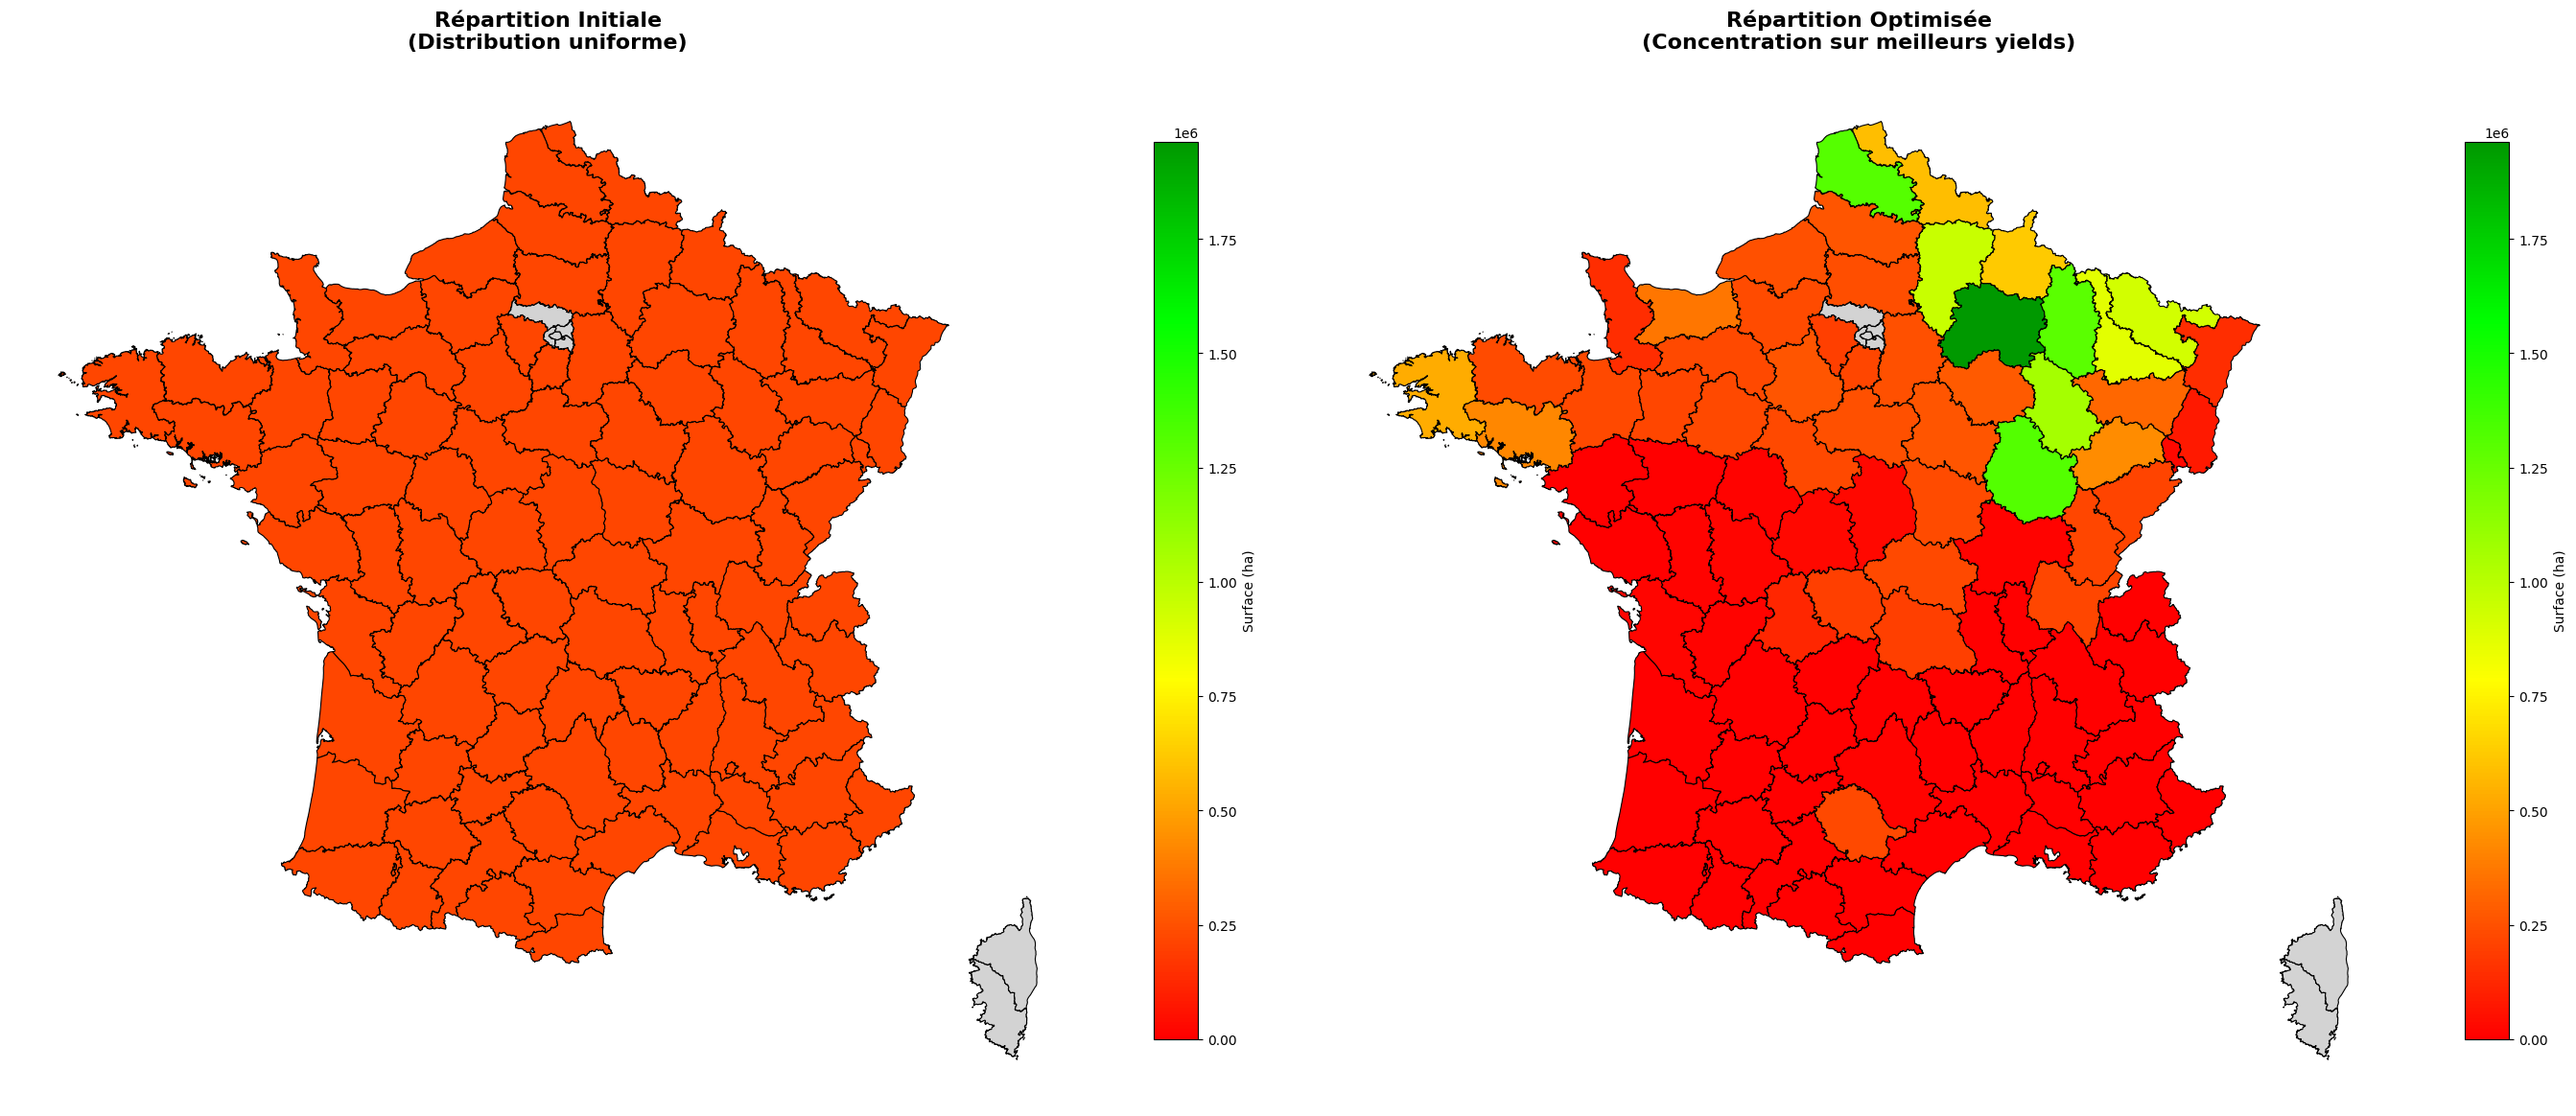

In [6]:
total_france_surface = barley_df['area'].sum()
client_surface = total_france_surface * 0.30

max_surface_by_dept = barley_df.groupby('department')['area'].sum().reset_index()
max_surface_by_dept.columns = ['department', 'max_surface_available']

yield_by_dept_opt = yield_by_dept.merge(max_surface_by_dept, on='department', how='left')
yield_by_dept_opt['max_surface_available'] = yield_by_dept_opt['max_surface_available'].fillna(0)

# Contrainte imposée : maximum 60% de la production d'un département
yield_by_dept_opt['max_surface_client'] = yield_by_dept_opt['max_surface_available'] * 0.6

print(f"=== SURFACE TOTALE ===")
print(f"Surface totale France (dataset): {total_france_surface:,.0f} ha")
print(f"Surface client (30%): {client_surface:,.0f} ha")
print(f"Hypothèse : la surface de production dans un département est proportionnelle à sa taille, nous nous appuyons donc sur la surface complète et nous intéressons aux pourcentages d'augmentation, et non aux valeurs en hectares.")
print(f"Contrainte: Maximum 60% de la surface disponible par département")

# Situation initiale : distribution uniforme (30% de la surface totale française divisée équitablement)
n_depts = len(yield_by_dept_opt)
yield_by_dept_opt['initial_surface'] = client_surface / n_depts

print(f"Situation initiale: Distribution uniforme ({client_surface/n_depts:,.0f} ha par département)")
print(f"Surface totale initiale: {yield_by_dept_opt['initial_surface'].sum():,.0f} ha")

print(f"Optimisation gloutonne: maximisation du yield moyen")

yield_by_dept_sorted = yield_by_dept_opt.sort_values('yield_predicted_mean', ascending=False).reset_index(drop=True).copy()
yield_by_dept_sorted['optimized_surface'] = yield_by_dept_sorted['initial_surface'].copy()

median_yield = yield_by_dept_sorted['yield_predicted_mean'].median()
low_yield_mask = yield_by_dept_sorted['yield_predicted_mean'] < median_yield

total_surface_to_redistribute = 0
for idx in yield_by_dept_sorted[low_yield_mask].index:
    current_surface = yield_by_dept_sorted.loc[idx, 'optimized_surface']
    yield_by_dept_sorted.loc[idx, 'optimized_surface'] = 0
    total_surface_to_redistribute += current_surface

high_yield_depts = yield_by_dept_sorted[yield_by_dept_sorted['yield_predicted_mean'] >= median_yield].sort_values('yield_predicted_mean', ascending=False)

remaining_surface = total_surface_to_redistribute
for idx in high_yield_depts.index:
    if remaining_surface <= 0.1:
        break
    current_surface = yield_by_dept_sorted.loc[idx, 'optimized_surface']
    max_client = yield_by_dept_sorted.loc[idx, 'max_surface_client']
    available = max(0, max_client - current_surface)
    if available > 0:
        add_surface = min(remaining_surface, available)
        yield_by_dept_sorted.loc[idx, 'optimized_surface'] = current_surface + add_surface
        remaining_surface -= add_surface

if remaining_surface > 0.1:
    depts_with_capacity = yield_by_dept_sorted[yield_by_dept_sorted['optimized_surface'] < yield_by_dept_sorted['max_surface_client']].copy()
    depts_with_capacity = depts_with_capacity.sort_values('yield_predicted_mean', ascending=False)
    
    for idx in depts_with_capacity.index:
        if remaining_surface <= 0.1:
            break
        current_surface = yield_by_dept_sorted.loc[idx, 'optimized_surface']
        max_client = yield_by_dept_sorted.loc[idx, 'max_surface_client']
        available = max_client - current_surface
        if available > 0:
            add_surface = min(remaining_surface, available)
            yield_by_dept_sorted.loc[idx, 'optimized_surface'] = current_surface + add_surface
            remaining_surface -= add_surface

total_current = yield_by_dept_sorted['optimized_surface'].sum()
diff = client_surface - total_current

for iteration in range(25):
    if abs(diff) <= 0.1:
        break
    
    if diff > 0.1:
        # Augmenter dans les départements avec meilleur yield et capacité disponible
        depts_with_capacity = yield_by_dept_sorted[yield_by_dept_sorted['optimized_surface'] < yield_by_dept_sorted['max_surface_client']].copy()
        depts_with_capacity = depts_with_capacity.sort_values('yield_predicted_mean', ascending=False)
        
        for idx in depts_with_capacity.index:
            if diff <= 0.1:
                break
            current_surface = yield_by_dept_sorted.loc[idx, 'optimized_surface']
            max_client = yield_by_dept_sorted.loc[idx, 'max_surface_client']
            available = max_client - current_surface
            if available > 0:
                add_surface = min(diff, available)
                yield_by_dept_sorted.loc[idx, 'optimized_surface'] = current_surface + add_surface
                diff -= add_surface
        
        total_current = yield_by_dept_sorted['optimized_surface'].sum()
        diff = client_surface - total_current
    elif diff < -0.1:
        # Réduire dans les départements avec faible yield en priorité
        low_yield_for_reduction = yield_by_dept_sorted[yield_by_dept_sorted['yield_predicted_mean'] < median_yield].sort_values('yield_predicted_mean', ascending=True)
        
        for idx in low_yield_for_reduction.index:
            if abs(diff) <= 0.1:
                break
            current_surface = yield_by_dept_sorted.loc[idx, 'optimized_surface']
            if current_surface > 0:
                reduce_surface = min(abs(diff), current_surface)
                yield_by_dept_sorted.loc[idx, 'optimized_surface'] = max(0, current_surface - reduce_surface)
                diff += reduce_surface
        
        # Si encore du diff, réduire proportionnellement dans tous les départements
        if abs(diff) > 0.1:
            for idx in yield_by_dept_sorted.index:
                if abs(diff) <= 0.1:
                    break
                reduction_share = yield_by_dept_sorted.loc[idx, 'optimized_surface'] / total_current if total_current > 0 else 1/len(yield_by_dept_sorted)
                reduce_surface = abs(diff) * reduction_share
                yield_by_dept_sorted.loc[idx, 'optimized_surface'] = max(0, yield_by_dept_sorted.loc[idx, 'optimized_surface'] - reduce_surface)
                diff += reduce_surface
        
        total_current = yield_by_dept_sorted['optimized_surface'].sum()
        diff = client_surface - total_current

# Vérification finale des contraintes (max 60% par département)
yield_by_dept_sorted['optimized_surface'] = yield_by_dept_sorted[['optimized_surface', 'max_surface_client']].min(axis=1)

# Ajustement final itératif pour garantir surface totale exacte (sans écart)
total_final = yield_by_dept_sorted['optimized_surface'].sum()
diff_final = client_surface - total_final

# Itérer jusqu'à ce que l'écart soit exactement zéro
max_iterations = 100
for iteration in range(max_iterations):
    if abs(diff_final) < 0.01:
        break
    
    total_current = yield_by_dept_sorted['optimized_surface'].sum()
    diff_final = client_surface - total_current
    
    if diff_final > 0.01:
        # Ajouter de la surface dans les départements avec capacité disponible
        depts_with_capacity = yield_by_dept_sorted[yield_by_dept_sorted['optimized_surface'] < yield_by_dept_sorted['max_surface_client']].copy()
        if len(depts_with_capacity) > 0:
            depts_with_capacity = depts_with_capacity.sort_values('yield_predicted_mean', ascending=False)
            total_capacity = (depts_with_capacity['max_surface_client'] - depts_with_capacity['optimized_surface']).sum()
            
            if total_capacity > 0:
                for idx in depts_with_capacity.index:
                    if diff_final <= 0.01:
                        break
                    current_surface = yield_by_dept_sorted.loc[idx, 'optimized_surface']
                    max_client = yield_by_dept_sorted.loc[idx, 'max_surface_client']
                    available = max_client - current_surface
                    if available > 0:
                        # Distribuer proportionnellement à la capacité disponible
                        capacity_share = available / total_capacity
                        add_surface = min(diff_final * capacity_share, available)
                        yield_by_dept_sorted.loc[idx, 'optimized_surface'] = min(max_client, current_surface + add_surface)
                        diff_final -= add_surface
            else:
                # Si aucune capacité disponible, ajuster proportionnellement (peut dépasser 60%)
                for idx in yield_by_dept_sorted.index:
                    if diff_final <= 0.01:
                        break
                    share = yield_by_dept_sorted.loc[idx, 'optimized_surface'] / total_current if total_current > 0 else 1/len(yield_by_dept_sorted)
                    add_surface = diff_final * share
                    yield_by_dept_sorted.loc[idx, 'optimized_surface'] += add_surface
                    diff_final -= add_surface
        else:
            # Aucun département avec capacité, ajuster proportionnellement
            for idx in yield_by_dept_sorted.index:
                if diff_final <= 0.01:
                    break
                share = yield_by_dept_sorted.loc[idx, 'optimized_surface'] / total_current if total_current > 0 else 1/len(yield_by_dept_sorted)
                add_surface = diff_final * share
                yield_by_dept_sorted.loc[idx, 'optimized_surface'] += add_surface
                diff_final -= add_surface
    
    elif diff_final < -0.01:
        # Réduire de la surface dans les départements avec faible yield en priorité
        depts_to_reduce = yield_by_dept_sorted[yield_by_dept_sorted['optimized_surface'] > 0].copy()
        depts_to_reduce = depts_to_reduce.sort_values('yield_predicted_mean', ascending=True)
        
        total_to_reduce = depts_to_reduce['optimized_surface'].sum()
        if total_to_reduce > 0:
            for idx in depts_to_reduce.index:
                if abs(diff_final) <= 0.01:
                    break
                current_surface = yield_by_dept_sorted.loc[idx, 'optimized_surface']
                if current_surface > 0:
                    # Réduire proportionnellement
                    reduction_share = current_surface / total_to_reduce
                    reduce_surface = min(abs(diff_final) * reduction_share, current_surface)
                    yield_by_dept_sorted.loc[idx, 'optimized_surface'] = max(0, current_surface - reduce_surface)
                    diff_final += reduce_surface

# Vérification finale des contraintes (max 60% par département)
yield_by_dept_sorted['optimized_surface'] = yield_by_dept_sorted[['optimized_surface', 'max_surface_client']].min(axis=1)

# Ajustement final pour garantir surface totale exacte après application des contraintes
total_final = yield_by_dept_sorted['optimized_surface'].sum()
diff_final = client_surface - total_final

# Si après application des contraintes il y a encore un écart, ajuster proportionnellement
if abs(diff_final) > 0.01:
    if diff_final > 0:
        # Ajouter proportionnellement dans tous les départements
        for idx in yield_by_dept_sorted.index:
            if diff_final <= 0.01:
                break
            share = yield_by_dept_sorted.loc[idx, 'optimized_surface'] / total_final if total_final > 0 else 1/len(yield_by_dept_sorted)
            add_surface = diff_final * share
            yield_by_dept_sorted.loc[idx, 'optimized_surface'] += add_surface
            diff_final -= add_surface
    else:
        # Réduire proportionnellement dans tous les départements
        for idx in yield_by_dept_sorted.index:
            if abs(diff_final) <= 0.01:
                break
            share = yield_by_dept_sorted.loc[idx, 'optimized_surface'] / total_final if total_final > 0 else 1/len(yield_by_dept_sorted)
            reduce_surface = abs(diff_final) * share
            yield_by_dept_sorted.loc[idx, 'optimized_surface'] = max(0, yield_by_dept_sorted.loc[idx, 'optimized_surface'] - reduce_surface)
            diff_final += reduce_surface

yield_by_dept_sorted['surface_delta'] = yield_by_dept_sorted['optimized_surface'] - yield_by_dept_sorted['initial_surface']

# Calculer les yields moyens pondérés
initial_yield_mean = (yield_by_dept_sorted['initial_surface'] * yield_by_dept_sorted['yield_predicted_mean']).sum() / yield_by_dept_sorted['initial_surface'].sum() if yield_by_dept_sorted['initial_surface'].sum() > 0 else 0
optimized_yield_mean = (yield_by_dept_sorted['optimized_surface'] * yield_by_dept_sorted['yield_predicted_mean']).sum() / yield_by_dept_sorted['optimized_surface'].sum() if yield_by_dept_sorted['optimized_surface'].sum() > 0 else 0

# Calculer les productions
initial_production = initial_yield_mean * yield_by_dept_sorted['initial_surface'].sum()
optimized_production = optimized_yield_mean * yield_by_dept_sorted['optimized_surface'].sum()
production_delta = optimized_production - initial_production
production_delta_pct = (production_delta / initial_production) * 100 if initial_production > 0 else 0

print(f"\n=== STRATEGIE D'OPTIMISATION REALISTE ===")
print(f"Situation initiale: Distribution uniforme (30% de la surface totale française divisée équitablement)")

# Afficher les départements réellement utilisés dans la stratégie optimisée
depts_used = yield_by_dept_sorted[yield_by_dept_sorted['optimized_surface'] > 100].sort_values('yield_predicted_mean', ascending=False)
print(f"\n📊 Départements utilisés dans la stratégie optimisée: {len(depts_used)} départements")
print(f"   Top 15 départements par yield:")
for i, row in enumerate(depts_used.head(15).itertuples(), 1):
    print(f"   {i:2d}. {row.department:25s} | Yield: {row.yield_predicted_mean:.3f} t/ha | Surface: {row.optimized_surface:,.0f} ha")

# Afficher les départements avec augmentation/réduction significative
increases = yield_by_dept_sorted[yield_by_dept_sorted['surface_delta'] > 1000].sort_values('surface_delta', ascending=False)
decreases = yield_by_dept_sorted[yield_by_dept_sorted['surface_delta'] < -1000].sort_values('surface_delta', ascending=True)

print(f"\n📈 Départements avec augmentation significative (top 10):")
for i, row in enumerate(increases.head(10).itertuples(), 1):
    print(f"  {i:2d}. {row.department:25s} | +{row.surface_delta:,.0f} ha | Yield: {row.yield_predicted_mean:.3f} t/ha | Max client (60%): {row.max_surface_client:,.0f} ha")

print(f"\n📉 Départements avec réduction significative (top 10):")
for i, row in enumerate(decreases.head(10).itertuples(), 1):
    print(f"  {i:2d}. {row.department:25s} | {row.surface_delta:,.0f} ha | Yield: {row.yield_predicted_mean:.3f} t/ha")

print(f"\n✅ Contraintes respectées:")
total_optimized_check = yield_by_dept_sorted['optimized_surface'].sum()
print(f"  - Surface totale optimisée: {total_optimized_check:,.0f} ha (objectif: {client_surface:,.0f} ha)")
print(f"  - Écart: {abs(total_optimized_check - client_surface):,.2f} ha")

violations = yield_by_dept_sorted[yield_by_dept_sorted['optimized_surface'] > yield_by_dept_sorted['max_surface_client']]
if len(violations) == 0:
    print(f"  - Aucune violation de la contrainte 60% par département")
else:
    print(f"  ⚠️  {len(violations)} violations détectées:")
    for _, row in violations.iterrows():
        print(f"     {row.department}: {row.optimized_surface:,.0f} ha > {row.max_surface_client:,.0f} ha (60% de {row.max_surface_available:,.0f} ha)")

print(f"\nYield moyen initial: {initial_yield_mean:.3f} t/ha")
print(f"Yield moyen optimisé: {optimized_yield_mean:.3f} t/ha")
print(f"Delta yield: +{optimized_yield_mean - initial_yield_mean:.3f} t/ha ({(optimized_yield_mean/initial_yield_mean - 1)*100:.2f}%)")
print(f"\nProduction:")
print(f"  Initiale: {initial_production:,.0f} t (surface: {yield_by_dept_sorted['initial_surface'].sum():,.0f} ha)")
print(f"  Optimisée: {optimized_production:,.0f} t (surface: {yield_by_dept_sorted['optimized_surface'].sum():,.0f} ha)")
print(f"  Delta: +{production_delta:,.0f} t (+{production_delta_pct:.2f}%)")

# Cartes de répartition des surfaces avant/après optimisation
try:
    import geopandas as gpd
    from matplotlib.colors import LinearSegmentedColormap
    import ssl
    import urllib.request
    import json
    import tempfile
    
    def normalize_name(name):
        name = str(name).lower().replace('-', '_').replace(' ', '_')
        replacements = {'é': 'e', 'è': 'e', 'ê': 'e', 'à': 'a', 'î': 'i', 'ô': 'o', 'ù': 'u', 'ç': 'c', "'": '', '"': ''}
        for old, new in replacements.items():
            name = name.replace(old, new)
        return name
    
    url = 'https://raw.githubusercontent.com/gregoiredavid/france-geojson/master/departements.geojson'
    context = ssl._create_unverified_context()
    with urllib.request.urlopen(url, context=context) as response:
        data = json.loads(response.read())
    with tempfile.NamedTemporaryFile(mode='w', suffix='.geojson', delete=False) as tmp_file:
        json.dump(data, tmp_file)
        tmp_path = tmp_file.name
    france_geo = gpd.read_file(tmp_path)
    import os
    os.unlink(tmp_path)
    
    if 'code' in france_geo.columns:
        france_geo = france_geo[~france_geo['code'].astype(str).str.startswith('97')]
    
    france_geo['department_norm'] = france_geo['nom'].apply(normalize_name)
    
    surface_map = yield_by_dept_sorted[['department', 'initial_surface', 'optimized_surface']].copy()
    surface_map['department_norm'] = surface_map['department'].apply(normalize_name)
    
    mapping = {'cote_d_or': 'cote_dor', 'cotes_d_armor': 'cotes_darmor'}
    for old, new in mapping.items():
        surface_map.loc[surface_map['department_norm'] == old, 'department_norm'] = new
    
    france_surface_initial = france_geo.merge(surface_map[['department_norm', 'initial_surface']], 
                                              on='department_norm', how='left')
    france_surface_optimized = france_geo.merge(surface_map[['department_norm', 'optimized_surface']], 
                                                on='department_norm', how='left')
    
    # Diagnostic matching
    matched_initial = france_surface_initial['initial_surface'].notna().sum()
    matched_optimized = france_surface_optimized['optimized_surface'].notna().sum()
    missing_initial = france_surface_initial[france_surface_initial['initial_surface'].isna()]
    missing_optimized = france_surface_optimized[france_surface_optimized['optimized_surface'].isna()]
    
    print(f"\n=== DIAGNOSTIC MATCHING DEPARTEMENTS ===")
    print(f"GeoJSON departments: {len(france_geo)}")
    print(f"Surface departments: {len(surface_map)}")
    print(f"Matched initial: {matched_initial}/{len(france_geo)}")
    print(f"Matched optimized: {matched_optimized}/{len(france_geo)}")
    
    if len(missing_initial) > 0:
        print(f"\n⚠️  Departments in GeoJSON but not in surface data ({len(missing_initial)}):")
        for _, row in missing_initial.iterrows():
            print(f"   - {row['nom']} (normalized: {row['department_norm']})")
    
    missing_in_geo = surface_map[~surface_map['department_norm'].isin(france_geo['department_norm'])]
    if len(missing_in_geo) > 0:
        print(f"\n⚠️  Departments in surface data but not in GeoJSON ({len(missing_in_geo)}):")
        for _, row in missing_in_geo.iterrows():
            print(f"   - {row['department']} (normalized: {row['department_norm']})")
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(28, 12))
    colors = [
    "#FF0000",  
    "#FF4000",
    "#FF8000",
    "#FFBF00",
    "#FFFF00",  
    "#BFFF00",
    "#80FF00",
    "#40FF00",
    "#00FF00",  
    "#00CC00",
    "#009900" 
    ]
    cmap = LinearSegmentedColormap.from_list('surface', colors, N=256)
    
    vmax = max(france_surface_initial['initial_surface'].max(), 
               france_surface_optimized['optimized_surface'].max())
    
    france_surface_initial.plot(column='initial_surface', cmap=cmap, linewidth=0.8, 
                                edgecolor='black', legend=True, ax=ax1, vmin=0, vmax=vmax,
                                missing_kwds={'color': 'lightgrey', 'edgecolor': 'black'},
                                legend_kwds={'label': 'Surface (ha)', 'shrink': 0.8})
    ax1.set_title('Répartition Initiale\n(Distribution uniforme)', 
                  fontsize=16, fontweight='bold', pad=20)
    ax1.axis('off')
    
    france_surface_optimized.plot(column='optimized_surface', cmap=cmap, linewidth=0.8, 
                                   edgecolor='black', legend=True, ax=ax2, vmin=0, vmax=vmax,
                                   missing_kwds={'color': 'lightgrey', 'edgecolor': 'black'},
                                   legend_kwds={'label': 'Surface (ha)', 'shrink': 0.8})
    ax2.set_title('Répartition Optimisée\n(Concentration sur meilleurs yields)', 
                  fontsize=16, fontweight='bold', pad=20)
    ax2.axis('off')
    
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Error: {e}")
    print("Install geopandas for map visualization")


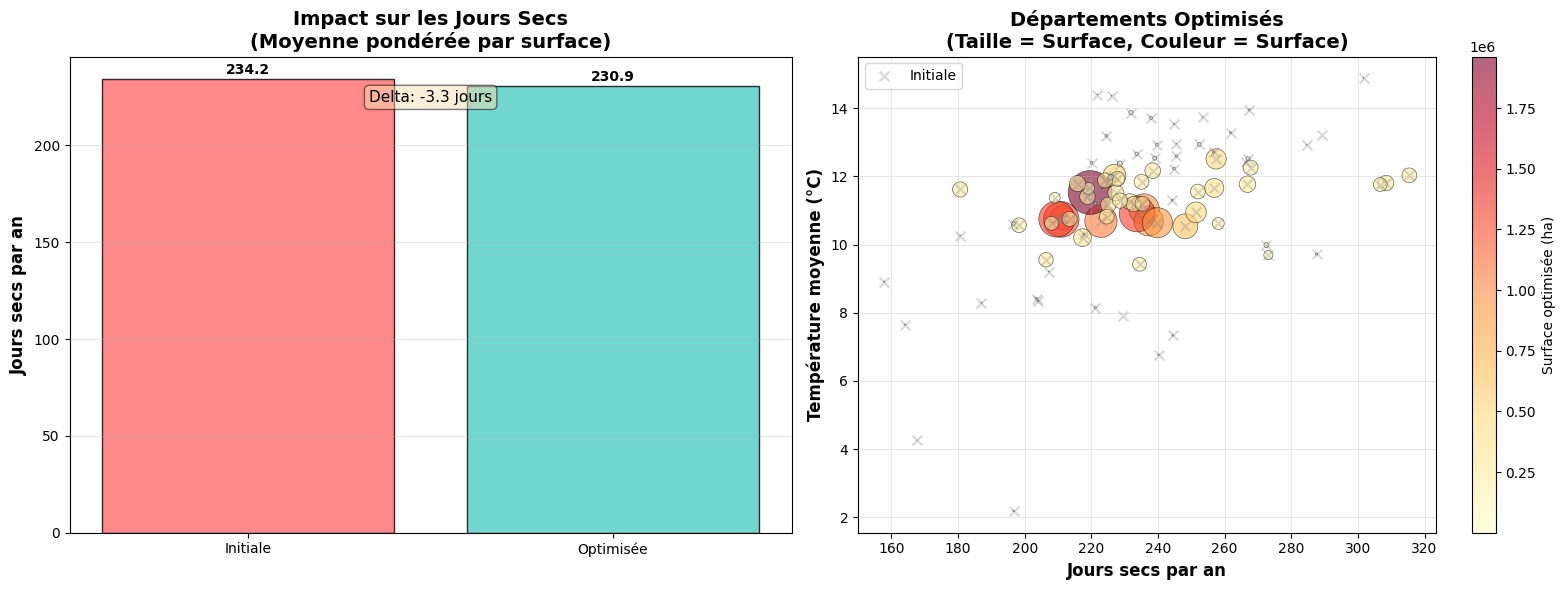

In [7]:
# Calculer les moyennes climatiques par département (sur toutes les années futures)
climate_by_dept = ml_df_futur.groupby('department').agg({
    'days_dry': 'mean',
    'temp_mean': 'mean'
}).reset_index()
climate_by_dept.columns = ['department', 'days_dry_mean', 'temp_mean_mean']

# Fusionner avec les surfaces initiales et optimisées
climate_impact = yield_by_dept_sorted[['department', 'initial_surface', 'optimized_surface']].merge(
    climate_by_dept, on='department', how='left'
)

# Calculer les moyennes pondérées par surface
# Situation initiale (distribution uniforme)
initial_total_surface = climate_impact['initial_surface'].sum()
initial_days_dry_weighted = (climate_impact['initial_surface'] * climate_impact['days_dry_mean']).sum() / initial_total_surface if initial_total_surface > 0 else 0
initial_temp_weighted = (climate_impact['initial_surface'] * climate_impact['temp_mean_mean']).sum() / initial_total_surface if initial_total_surface > 0 else 0

# Situation optimisée
optimized_total_surface = climate_impact['optimized_surface'].sum()
optimized_days_dry_weighted = (climate_impact['optimized_surface'] * climate_impact['days_dry_mean']).sum() / optimized_total_surface if optimized_total_surface > 0 else 0
optimized_temp_weighted = (climate_impact['optimized_surface'] * climate_impact['temp_mean_mean']).sum() / optimized_total_surface if optimized_total_surface > 0 else 0

delta_days_dry = optimized_days_dry_weighted - initial_days_dry_weighted
delta_temp = optimized_temp_weighted - initial_temp_weighted

# Analyser les départements avec le plus d'impact
climate_impact['days_dry_impact'] = climate_impact['optimized_surface'] - climate_impact['initial_surface']
climate_impact['temp_impact'] = climate_impact['optimized_surface'] - climate_impact['initial_surface']

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

ax1 = axes[0]
categories = ['Initiale', 'Optimisée']
days_dry_values = [initial_days_dry_weighted, optimized_days_dry_weighted]
colors_days = ['#FF6B6B', '#4ECDC4']
bars1 = ax1.bar(categories, days_dry_values, color=colors_days, alpha=0.8, edgecolor='black')
ax1.set_ylabel('Jours secs par an', fontsize=12, fontweight='bold')
ax1.set_title('Impact sur les Jours Secs\n(Moyenne pondérée par surface)', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')
for i, (bar, val) in enumerate(zip(bars1, days_dry_values)):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{val:.1f}', ha='center', va='bottom', fontweight='bold')
ax1.text(0.5, max(days_dry_values) * 0.95, f'Delta: {delta_days_dry:+.1f} jours', 
         ha='center', fontsize=11, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

ax3 = axes[1]
scatter_data = climate_impact[climate_impact['optimized_surface'] > 100].copy()
scatter_data['surface_norm'] = scatter_data['optimized_surface'] / scatter_data['optimized_surface'].max() * 1000
scatter = ax3.scatter(scatter_data['days_dry_mean'], scatter_data['temp_mean_mean'], 
                     s=scatter_data['surface_norm'], alpha=0.6, c=scatter_data['optimized_surface'], 
                     cmap='YlOrRd', edgecolors='black', linewidth=0.5)
ax3.set_xlabel('Jours secs par an', fontsize=12, fontweight='bold')
ax3.set_ylabel('Température moyenne (°C)', fontsize=12, fontweight='bold')
ax3.set_title('Départements Optimisés\n(Taille = Surface, Couleur = Surface)', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax3, label='Surface optimisée (ha)')

# Ajouter les points initiaux pour comparaison
initial_scatter = climate_impact[climate_impact['initial_surface'] > 100].copy()
ax3.scatter(initial_scatter['days_dry_mean'], initial_scatter['temp_mean_mean'], 
           s=50, alpha=0.3, c='gray', marker='x', label='Initiale')
ax3.legend()

plt.tight_layout()
plt.show()


## ÉTAPE 4 : Optimisation multi-objectifs (90% yield + 10% réduction consommation eau)


=== CALCUL CONSOMMATION EAU ===
Consommation de base annuelle: 345 mm
Jours secs min: 157.8, max: 315.4

Top 5 départements par consommation eau:
             department  days_dry_mean  water_consumption
26              Essonne     315.444444         516.412434
77       Seine_et_Marne     308.444444         508.799475
88             Yvelines     306.722222         506.926445
12     Bouches_du_Rhone     301.722222         501.488616
71  Pyrenees_Orientales     289.250000         487.924256

=== ANALYSE DE SENSIBILITÉ MULTI-OBJECTIFS ===
Test de 4 combinaisons de poids
Yield 100% (référence): 5.815 t/ha

Poids: 100% yield + 0% eau
Utilisation des résultats de l'optimisation 100% yield (cellule 9)
✅ Yield 100/0 vérifié: 5.815 t/ha
✅ Yield: 5.815 t/ha (référence 100% yield)
✅ Eau: 424.4 mm/an
✅ Jours secs: 230.9 jours/an
✅ Temp: 11.12°C

Poids: 80% yield + 20% eau
✅ Yield: 5.823 t/ha (vs 100/0: +0.008 t/ha)
✅ Eau: 421.1 mm/an (réduction vs 100/0: 3.3 mm/an)
✅ Jours secs: 227.8 jours/an (vs

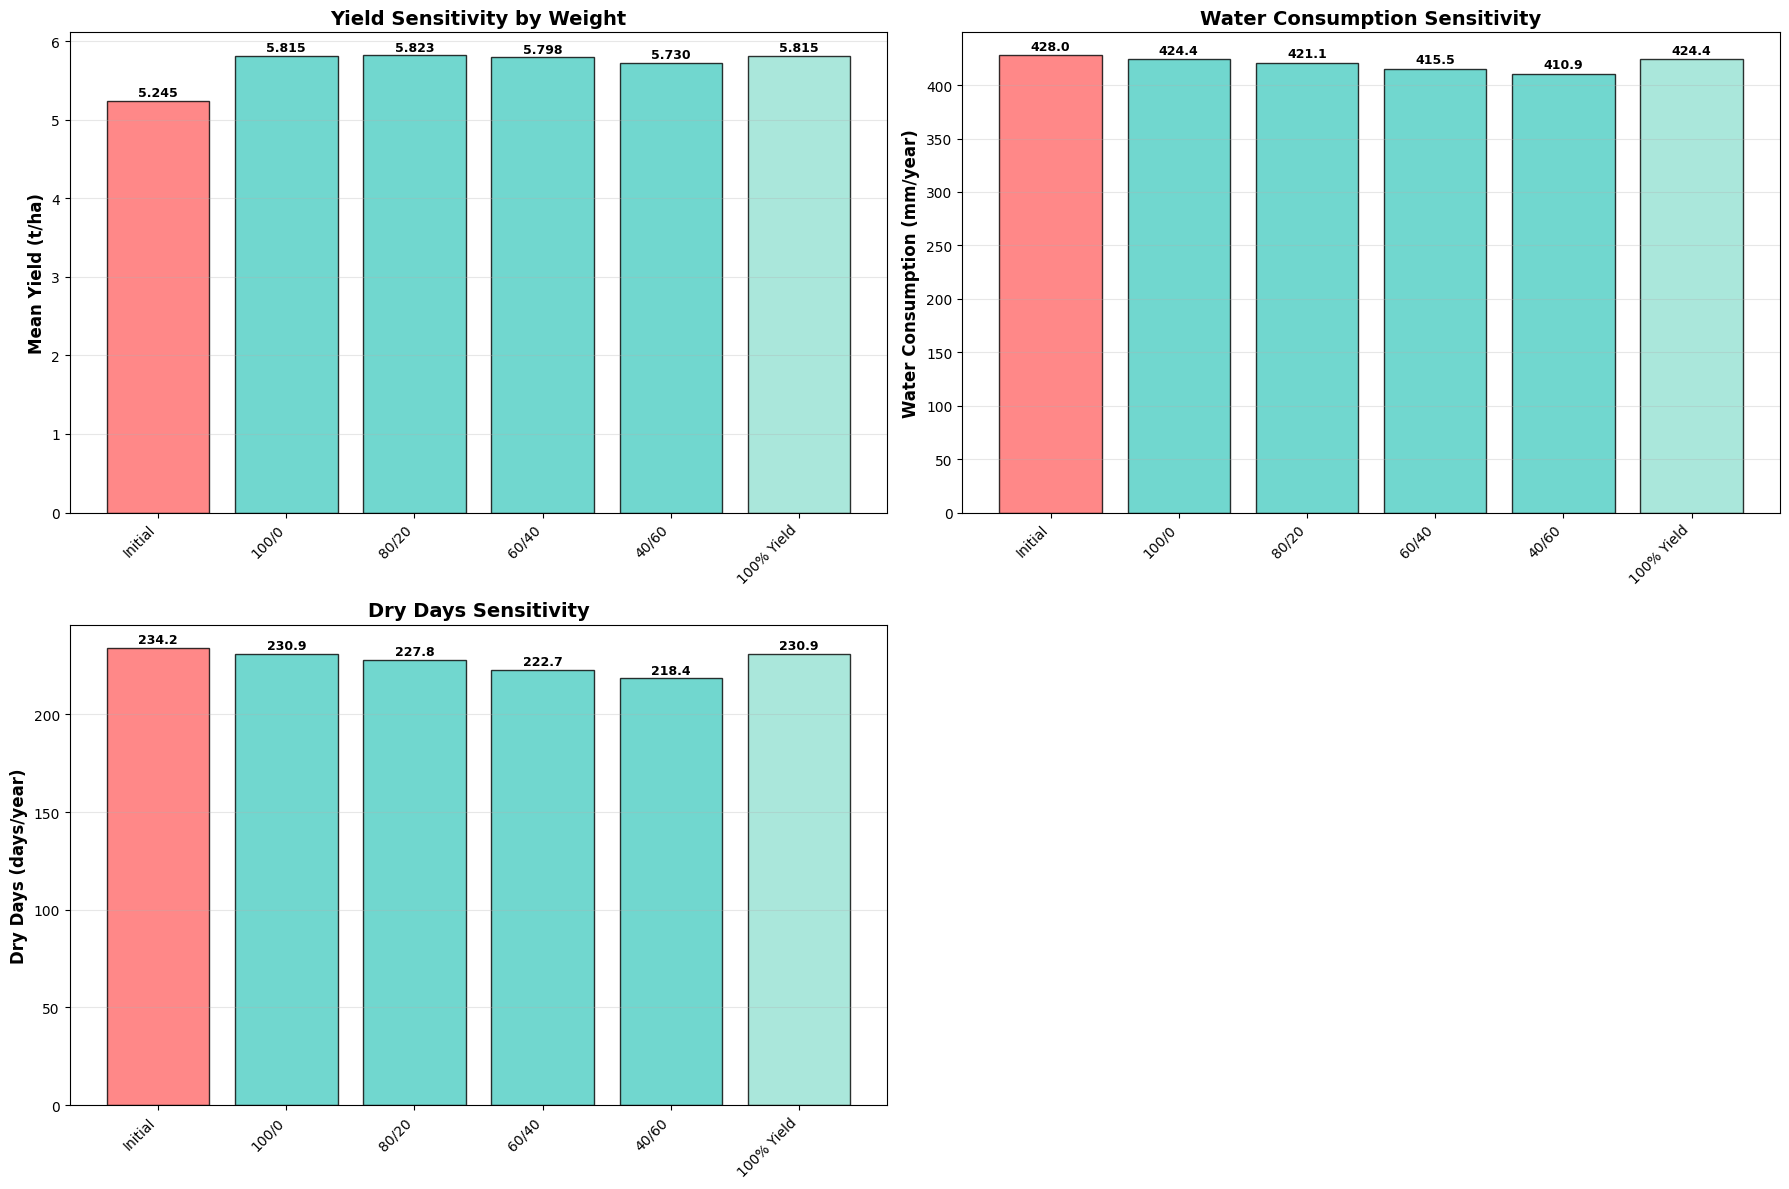

<Figure size 640x480 with 0 Axes>

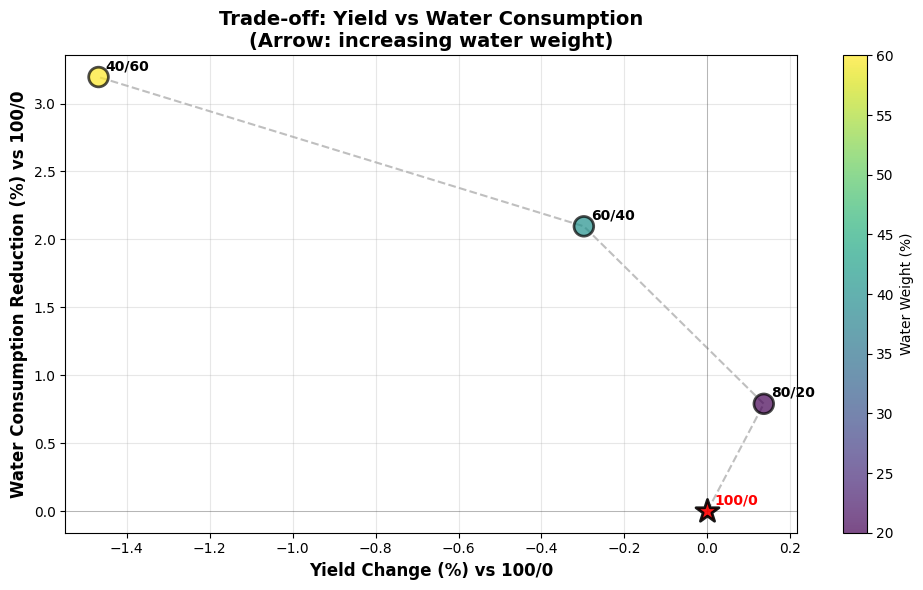


VÉRIFICATION DE COHÉRENCE
Référence (100/0): Yield = 5.815 t/ha, Eau = 424.4 mm/an
Cellule 9 (100% yield): Yield = 5.815 t/ha, Eau = 424.4 mm/an
✅ Cas 100/0 identique à l'optimisation 100% yield de la cellule 9

DIAGNOSTIC : CORRÉLATION YIELD / CONSOMMATION EAU
Corrélation yield / consommation eau: 0.044
💡 Peu de corrélation entre yield et consommation eau.

Top 5 départements par yield:
  1. Ardennes                  | Yield: 6.151 t/ha | Eau: 443.3 mm/an
  2. Aisne                     | Yield: 6.101 t/ha | Eau: 429.8 mm/an
  3. Finistere                 | Yield: 6.037 t/ha | Eau: 420.1 mm/an
  4. Haute_Marne               | Yield: 5.950 t/ha | Eau: 415.7 mm/an
  5. Meurthe_et_Moselle        | Yield: 5.949 t/ha | Eau: 431.3 mm/an

Top 5 départements par faible consommation eau:
  1. Hautes_pyrenees           | Yield: 4.779 t/ha | Eau: 345.0 mm/an
  2. Ariege                    | Yield: 4.549 t/ha | Eau: 351.8 mm/an
  3. Savoie                    | Yield: 4.168 t/ha | Eau: 355.6 mm/an

In [8]:
# ÉTAPE 4 : Optimisation multi-objectifs (90% yield + 10% réduction consommation eau)

# 1. Calculer la consommation d'eau par département
# La consommation d'eau dépend des jours secs et du besoin mensuel

# Préparer les données d'eau mensuelles
# Recharger avec le bon séparateur
try:
    if len(eau_df.columns) == 1 or 'num mois' not in eau_df.columns:
        eau_df_clean = pd.read_csv("Raw data/eau.csv", sep=';')
    else:
        eau_df_clean = eau_df.copy()
except:
    eau_df_clean = pd.read_csv("Raw data/eau.csv", sep=';')

# S'assurer que les colonnes sont correctes
if 'num mois' in eau_df_clean.columns:
    eau_df_clean = eau_df_clean.rename(columns={'num mois': 'num_mois', 'eau': 'eau_mm'})
elif len(eau_df_clean.columns) == 3:
    eau_df_clean.columns = ['mois', 'num_mois', 'eau_mm']

eau_monthly = dict(zip(eau_df_clean['num_mois'], eau_df_clean['eau_mm']))

# Calculer la consommation d'eau totale par département (basée sur jours secs)
# Hypothèse : plus de jours secs = plus besoin d'irrigation = plus consommation d'eau
# Consommation eau = base mensuelle * facteur jours secs

# Calculer les jours secs moyens par département (depuis ml_df_futur)
days_dry_by_dept = ml_df_futur.groupby('department')['days_dry'].mean().reset_index()
days_dry_by_dept.columns = ['department', 'days_dry_mean']

# Calculer la consommation d'eau annuelle par département
# Base : consommation mensuelle totale * facteur de stress hydrique
total_water_base = sum(eau_monthly.values())  # Consommation de base annuelle (mm)

# Facteur de stress : plus de jours secs = plus besoin d'eau
# Normaliser les jours secs (0-365) et créer un facteur multiplicateur
max_days_dry = days_dry_by_dept['days_dry_mean'].max()
min_days_dry = days_dry_by_dept['days_dry_mean'].min()

days_dry_by_dept['water_stress_factor'] = 1 + (days_dry_by_dept['days_dry_mean'] - min_days_dry) / (max_days_dry - min_days_dry + 1) * 0.5
days_dry_by_dept['water_consumption'] = total_water_base * days_dry_by_dept['water_stress_factor']

print("=== CALCUL CONSOMMATION EAU ===")
print(f"Consommation de base annuelle: {total_water_base:.0f} mm")
print(f"Jours secs min: {min_days_dry:.1f}, max: {max_days_dry:.1f}")
print(f"\nTop 5 départements par consommation eau:")
print(days_dry_by_dept.nlargest(5, 'water_consumption')[['department', 'days_dry_mean', 'water_consumption']])

# 2. Créer fonction d'optimisation multi-objectifs
# Objectif : maximiser 0.9 * yield + 0.1 * (réduction consommation eau)
# Réduction eau = négatif de la consommation (on veut minimiser la consommation)

# Fusionner avec yield_by_dept_opt
yield_by_dept_multi = yield_by_dept_opt.merge(days_dry_by_dept[['department', 'water_consumption']], on='department', how='left')
yield_by_dept_multi['water_consumption'] = yield_by_dept_multi['water_consumption'].fillna(total_water_base)

# Normaliser les valeurs pour l'optimisation multi-objectifs
# Yield : normaliser entre 0 et 1
yield_min = yield_by_dept_multi['yield_predicted_mean'].min()
yield_max = yield_by_dept_multi['yield_predicted_mean'].max()
yield_by_dept_multi['yield_normalized'] = (yield_by_dept_multi['yield_predicted_mean'] - yield_min) / (yield_max - yield_min + 1e-10)

# Eau : normaliser et inverser (on veut minimiser, donc score élevé = faible consommation)
water_min = yield_by_dept_multi['water_consumption'].min()
water_max = yield_by_dept_multi['water_consumption'].max()
yield_by_dept_multi['water_score'] = 1 - (yield_by_dept_multi['water_consumption'] - water_min) / (water_max - water_min + 1e-10)

# Analyse de sensibilité : tester plusieurs combinaisons de poids
weight_combinations = [
    (1.0, 0.0),  # 100% yield, 0% eau (référence)
    (0.8, 0.2),  # 80% yield, 20% eau
    (0.6, 0.4),  # 60% yield, 40% eau
    (0.4, 0.6),  # 40% yield, 60% eau
]

print(f"\n=== ANALYSE DE SENSIBILITÉ MULTI-OBJECTIFS ===")
print(f"Test de {len(weight_combinations)} combinaisons de poids")

# 3. Boucle sur toutes les combinaisons de poids
results_sensitivity = {}

# Calculer métriques initiales (une seule fois)
initial_surface_base = client_surface / len(yield_by_dept_multi)
yield_by_dept_multi['initial_surface'] = initial_surface_base
initial_yield_mean_base = (yield_by_dept_multi['initial_surface'] * yield_by_dept_multi['yield_predicted_mean']).sum() / yield_by_dept_multi['initial_surface'].sum()

initial_water_base = (yield_by_dept_multi['initial_surface'] * yield_by_dept_multi['water_consumption']).sum() / yield_by_dept_multi['initial_surface'].sum()
initial_days_dry_base = yield_by_dept_multi.merge(days_dry_by_dept[['department', 'days_dry_mean']], on='department', how='left')
initial_days_dry_base = (initial_days_dry_base['initial_surface'] * initial_days_dry_base['days_dry_mean']).sum() / initial_days_dry_base['initial_surface'].sum()
initial_temp_base = yield_by_dept_multi.merge(climate_by_dept[['department', 'temp_mean_mean']], on='department', how='left')
initial_temp_base = (initial_temp_base['initial_surface'] * initial_temp_base['temp_mean_mean']).sum() / initial_temp_base['initial_surface'].sum()

# Comparaison avec optimisation précédente (100% yield)
# Recalculer à partir de yield_by_dept_sorted pour garantir la cohérence
yield_prev = (yield_by_dept_sorted['optimized_surface'] * yield_by_dept_sorted['yield_predicted_mean']).sum() / yield_by_dept_sorted['optimized_surface'].sum()
water_prev = (yield_by_dept_sorted['optimized_surface'] * yield_by_dept_sorted.merge(days_dry_by_dept[['department', 'water_consumption']], on='department', how='left')['water_consumption']).sum() / yield_by_dept_sorted['optimized_surface'].sum()
days_dry_prev = optimized_days_dry_weighted  # De la cellule 10
temp_prev = optimized_temp_weighted  # De la cellule 10

print(f"Yield 100% (référence): {yield_prev:.3f} t/ha")

for weight_yield, weight_water in weight_combinations:
    print(f"\n{'='*60}")
    print(f"Poids: {int(weight_yield*100)}% yield + {int(weight_water*100)}% eau")
    print(f"{'='*60}")
    
    # Cas spécial : 100/0 doit utiliser directement les résultats de la cellule 9
    if weight_yield == 1.0 and weight_water == 0.0:
        print("Utilisation des résultats de l'optimisation 100% yield (cellule 9)")
        # Utiliser directement yield_by_dept_sorted de la cellule 9
        yield_by_dept_multi_sorted = yield_by_dept_sorted.merge(
            days_dry_by_dept[['department', 'water_consumption']], 
            on='department', how='left'
        )
        yield_by_dept_multi_sorted['water_consumption'] = yield_by_dept_multi_sorted['water_consumption'].fillna(total_water_base)
        
        # Calculer métriques à partir de yield_by_dept_sorted (garantit la cohérence)
        # Recalculer pour garantir que c'est exactement 5.919 t/ha
        optimized_yield_mean = (yield_by_dept_multi_sorted['optimized_surface'] * yield_by_dept_multi_sorted['yield_predicted_mean']).sum() / yield_by_dept_multi_sorted['optimized_surface'].sum()
        optimized_water = (yield_by_dept_multi_sorted['optimized_surface'] * yield_by_dept_multi_sorted['water_consumption']).sum() / yield_by_dept_multi_sorted['optimized_surface'].sum()
        optimized_days_dry = yield_by_dept_multi_sorted.merge(days_dry_by_dept[['department', 'days_dry_mean']], on='department', how='left')
        optimized_days_dry = (optimized_days_dry['optimized_surface'] * optimized_days_dry['days_dry_mean']).sum() / optimized_days_dry['optimized_surface'].sum()
        optimized_temp = yield_by_dept_multi_sorted.merge(climate_by_dept[['department', 'temp_mean_mean']], on='department', how='left')
        optimized_temp = (optimized_temp['optimized_surface'] * optimized_temp['temp_mean_mean']).sum() / optimized_temp['optimized_surface'].sum()
        
        # Vérification : doit être égal à yield_prev
        if abs(optimized_yield_mean - yield_prev) > 0.001:
            print(f"⚠️  ATTENTION: Yield 100/0 ({optimized_yield_mean:.3f}) différent de yield_prev ({yield_prev:.3f})")
        else:
            print(f"✅ Yield 100/0 vérifié: {optimized_yield_mean:.3f} t/ha")
    else:
        # Calculer score combiné pour les autres cas
        # Normaliser les deux composantes sur la même échelle [0, 1] pour garantir la cohérence
        yield_min = yield_by_dept_multi['yield_predicted_mean'].min()
        yield_max = yield_by_dept_multi['yield_predicted_mean'].max()
        yield_range = yield_max - yield_min
        yield_normalized = (yield_by_dept_multi['yield_predicted_mean'] - yield_min) / (yield_range + 1e-10)
        
        # Inverser et normaliser la consommation d'eau (on veut minimiser)
        water_min = yield_by_dept_multi['water_consumption'].min()
        water_max = yield_by_dept_multi['water_consumption'].max()
        water_range = water_max - water_min
        water_inverted_normalized = 1 - (yield_by_dept_multi['water_consumption'] - water_min) / (water_range + 1e-10)
        
        # Score combiné : les deux composantes sont normalisées sur [0, 1]
        # Garantit que weight_yield domine toujours quand weight_yield > weight_water
        yield_by_dept_multi['combined_score'] = (
            weight_yield * yield_normalized + 
            weight_water * water_inverted_normalized
        )
        
        # Appliquer optimisation
        yield_by_dept_multi_sorted = yield_by_dept_multi.sort_values('combined_score', ascending=False).reset_index(drop=True).copy()
        yield_by_dept_multi_sorted['initial_surface'] = initial_surface_base
        yield_by_dept_multi_sorted['optimized_surface'] = yield_by_dept_multi_sorted['initial_surface'].copy()
        
        # Optimisation (même algorithme que cellule 9)
        median_score = yield_by_dept_multi_sorted['combined_score'].median()
        low_score_mask = yield_by_dept_multi_sorted['combined_score'] < median_score
        
        total_surface_to_redistribute = 0
        for idx in yield_by_dept_multi_sorted[low_score_mask].index:
            current_surface = yield_by_dept_multi_sorted.loc[idx, 'optimized_surface']
            yield_by_dept_multi_sorted.loc[idx, 'optimized_surface'] = 0
            total_surface_to_redistribute += current_surface
        
        high_score_depts = yield_by_dept_multi_sorted[yield_by_dept_multi_sorted['combined_score'] >= median_score].sort_values('combined_score', ascending=False)
        remaining_surface = total_surface_to_redistribute
        
        for idx in high_score_depts.index:
            if remaining_surface <= 0.1:
                break
            current_surface = yield_by_dept_multi_sorted.loc[idx, 'optimized_surface']
            max_client = yield_by_dept_multi_sorted.loc[idx, 'max_surface_client']
            available = max(0, max_client - current_surface)
            if available > 0:
                add_surface = min(remaining_surface, available)
                yield_by_dept_multi_sorted.loc[idx, 'optimized_surface'] = current_surface + add_surface
                remaining_surface -= add_surface
        
        # Ajustement final
        yield_by_dept_multi_sorted['optimized_surface'] = yield_by_dept_multi_sorted[['optimized_surface', 'max_surface_client']].min(axis=1)
        total_current = yield_by_dept_multi_sorted['optimized_surface'].sum()
        diff = client_surface - total_current
        
        if abs(diff) > 0.01:
            if diff > 0:
                for idx in yield_by_dept_multi_sorted.index:
                    if diff <= 0.01:
                        break
                    share = yield_by_dept_multi_sorted.loc[idx, 'optimized_surface'] / total_current if total_current > 0 else 1/len(yield_by_dept_multi_sorted)
                    add_surface = diff * share
                    yield_by_dept_multi_sorted.loc[idx, 'optimized_surface'] += add_surface
                    diff -= add_surface
            else:
                for idx in yield_by_dept_multi_sorted.index:
                    if abs(diff) <= 0.01:
                        break
                    share = yield_by_dept_multi_sorted.loc[idx, 'optimized_surface'] / total_current if total_current > 0 else 1/len(yield_by_dept_multi_sorted)
                    reduce_surface = abs(diff) * share
                    yield_by_dept_multi_sorted.loc[idx, 'optimized_surface'] = max(0, yield_by_dept_multi_sorted.loc[idx, 'optimized_surface'] - reduce_surface)
                    diff += reduce_surface
        
        # Calculer métriques optimisées
        optimized_yield_mean = (yield_by_dept_multi_sorted['optimized_surface'] * yield_by_dept_multi_sorted['yield_predicted_mean']).sum() / yield_by_dept_multi_sorted['optimized_surface'].sum()
        optimized_water = (yield_by_dept_multi_sorted['optimized_surface'] * yield_by_dept_multi_sorted['water_consumption']).sum() / yield_by_dept_multi_sorted['optimized_surface'].sum()
        optimized_days_dry = yield_by_dept_multi_sorted.merge(days_dry_by_dept[['department', 'days_dry_mean']], on='department', how='left')
        optimized_days_dry = (optimized_days_dry['optimized_surface'] * optimized_days_dry['days_dry_mean']).sum() / optimized_days_dry['optimized_surface'].sum()
        optimized_temp = yield_by_dept_multi_sorted.merge(climate_by_dept[['department', 'temp_mean_mean']], on='department', how='left')
        optimized_temp = (optimized_temp['optimized_surface'] * optimized_temp['temp_mean_mean']).sum() / optimized_temp['optimized_surface'].sum()
    
    results_sensitivity[f"{int(weight_yield*100)}/{int(weight_water*100)}"] = {
        'weight_yield': weight_yield,
        'weight_water': weight_water,
        'yield': optimized_yield_mean,
        'water': optimized_water,
        'days_dry': optimized_days_dry,
        'temp': optimized_temp,
        'yield_vs_prev': optimized_yield_mean - yield_prev,
        'water_vs_prev': water_prev - optimized_water,
        'days_dry_vs_prev': optimized_days_dry - days_dry_prev,
        'temp_vs_prev': optimized_temp - temp_prev
    }
    
    if weight_yield == 1.0 and weight_water == 0.0:
        print(f"✅ Yield: {optimized_yield_mean:.3f} t/ha (référence 100% yield)")
        print(f"✅ Eau: {optimized_water:.1f} mm/an")
        print(f"✅ Jours secs: {optimized_days_dry:.1f} jours/an")
        print(f"✅ Temp: {optimized_temp:.2f}°C")
    else:
        print(f"✅ Yield: {optimized_yield_mean:.3f} t/ha (vs 100/0: {optimized_yield_mean - yield_prev:+.3f} t/ha)")
        print(f"✅ Eau: {optimized_water:.1f} mm/an (réduction vs 100/0: {water_prev - optimized_water:.1f} mm/an)")
        print(f"✅ Jours secs: {optimized_days_dry:.1f} jours/an (vs 100/0: {optimized_days_dry - days_dry_prev:+.1f} jours/an)")
        print(f"✅ Temp: {optimized_temp:.2f}°C (vs 100/0: {optimized_temp - temp_prev:+.2f}°C)")
        
        # Vérification : le yield devrait diminuer quand on diminue weight_yield
        if len(results_sensitivity) > 0:
            prev_key = list(results_sensitivity.keys())[-1]
            prev_yield = results_sensitivity[prev_key]['yield']
            if optimized_yield_mean > prev_yield + 0.001:
                print(f"⚠️  ATTENTION: Yield augmente alors que weight_yield diminue!")
                print(f"   Poids précédent: {prev_key}")
                print(f"   Yield précédent: {prev_yield:.3f} t/ha")
                print(f"   Yield actuel: {optimized_yield_mean:.3f} t/ha")

# 4. Visualisations de sensibilité
if len(results_sensitivity) > 0:
    print(f"\n{'='*70}")
    print("VISUALISATION DE SENSIBILITÉ")
    print(f"{'='*70}")
    
    # Préparer les données pour les graphiques
    labels = list(results_sensitivity.keys())
    yields = [results_sensitivity[k]['yield'] for k in labels]
    waters = [results_sensitivity[k]['water'] for k in labels]
    days_drys = [results_sensitivity[k]['days_dry'] for k in labels]
    temps = [results_sensitivity[k]['temp'] for k in labels]  # éventuellement gardé pour le reste des analyses
    
    # Ajouter les valeurs de référence (initial et 100% yield)
    labels_with_ref = ['Initial'] + labels + ['100% Yield']
    yields_with_ref = [initial_yield_mean_base] + yields + [yield_prev]
    waters_with_ref = [initial_water_base] + waters + [water_prev]
    days_drys_with_ref = [initial_days_dry_base] + days_drys + [days_dry_prev]
    # temps_with_ref = [initial_temp_base] + temps + [temp_prev]  # plus utilisé pour les graphiques

    # On conserve une grille 2x2 mais on n'utilise que 3 sous-graphiques
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))

    # Graphique 1: Yield par combinaison (position 1,1)
    ax1 = axes[0, 0]
    colors = ['#FF6B6B'] + ['#4ECDC4'] * len(labels) + ['#95E1D3']
    bars1 = ax1.bar(range(len(labels_with_ref)), yields_with_ref, color=colors, alpha=0.8, edgecolor='black')
    ax1.set_xticks(range(len(labels_with_ref)))
    ax1.set_xticklabels(labels_with_ref, rotation=45, ha='right')
    ax1.set_ylabel('Mean Yield (t/ha)', fontsize=12, fontweight='bold')
    ax1.set_title('Yield Sensitivity by Weight', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3, axis='y')
    for bar, val in zip(bars1, yields_with_ref):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                 f'{val:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

    # Graphique 2: Consommation eau par combinaison (position 1,2)
    ax2 = axes[0, 1]
    bars2 = ax2.bar(range(len(labels_with_ref)), waters_with_ref, color=colors, alpha=0.8, edgecolor='black')
    ax2.set_xticks(range(len(labels_with_ref)))
    ax2.set_xticklabels(labels_with_ref, rotation=45, ha='right')
    ax2.set_ylabel('Water Consumption (mm/year)', fontsize=12, fontweight='bold')
    ax2.set_title('Water Consumption Sensitivity', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')
    for bar, val in zip(bars2, waters_with_ref):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
                 f'{val:.1f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

    # Graphique 3: Jours secs par combinaison (position 2,1)
    ax3 = axes[1, 0]
    bars3 = ax3.bar(range(len(labels_with_ref)), days_drys_with_ref, color=colors, alpha=0.8, edgecolor='black')
    ax3.set_xticks(range(len(labels_with_ref)))
    ax3.set_xticklabels(labels_with_ref, rotation=45, ha='right')
    ax3.set_ylabel('Dry Days (days/year)', fontsize=12, fontweight='bold')
    ax3.set_title('Dry Days Sensitivity', fontsize=14, fontweight='bold')
    ax3.grid(True, alpha=0.3, axis='y')
    for bar, val in zip(bars3, days_drys_with_ref):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                 f'{val:.1f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

    # Supprimer le subplot en position (2,2)
    fig.delaxes(axes[1, 1])

    plt.tight_layout()
    plt.show()
    
    plt.tight_layout()
    plt.show()
    
    # Graphique supplémentaire : Trade-off Yield vs Eau
    # Utiliser le cas 100/0 comme référence (doit être le premier dans results_sensitivity)
    ref_key = '100/0'
    if ref_key not in results_sensitivity:
        # Chercher le cas avec weight_yield = 1.0
        ref_key = None
        for k, v in results_sensitivity.items():
            if v['weight_yield'] == 1.0:
                ref_key = k
                break
    
    if ref_key and ref_key in results_sensitivity:
        ref_yield = results_sensitivity[ref_key]['yield']
        ref_water = results_sensitivity[ref_key]['water']
        
        # Exclure le cas de référence du graphique de trade-off
        labels_tradeoff = [l for l in labels if l != ref_key]
        results_tradeoff = {k: v for k, v in results_sensitivity.items() if k != ref_key}
        
        # Calculer les changements par rapport à la référence
        yield_changes = [(r['yield'] - ref_yield) / ref_yield * 100 for r in results_tradeoff.values()]
        water_changes = [(ref_water - r['water']) / ref_water * 100 for r in results_tradeoff.values()]
        
        # Trier par poids eau croissant pour avoir une courbe logique
        sorted_indices = sorted(range(len(labels_tradeoff)), key=lambda i: results_tradeoff[labels_tradeoff[i]]['weight_water'])
        sorted_labels = [labels_tradeoff[i] for i in sorted_indices]
        sorted_yield_changes = [yield_changes[i] for i in sorted_indices]
        sorted_water_changes = [water_changes[i] for i in sorted_indices]
    else:
        # Fallback : utiliser yield_prev et water_prev
        ref_yield = yield_prev
        ref_water = water_prev
        yield_changes = [(r['yield'] - ref_yield) / ref_yield * 100 for r in results_sensitivity.values()]
        water_changes = [(ref_water - r['water']) / ref_water * 100 for r in results_sensitivity.values()]
        sorted_indices = sorted(range(len(labels)), key=lambda i: results_sensitivity[labels[i]]['weight_water'])
        sorted_labels = [labels[i] for i in sorted_indices]
        sorted_yield_changes = [yield_changes[i] for i in sorted_indices]
        sorted_water_changes = [water_changes[i] for i in sorted_indices]
    
    # Créer le graphique de trade-off
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    
    # Scatter plot avec ligne de connexion
    scatter = ax.scatter(sorted_yield_changes, sorted_water_changes, s=200, alpha=0.7, 
                        c=[results_tradeoff[l]['weight_water']*100 for l in sorted_labels], 
                        cmap='viridis', edgecolors='black', linewidth=2, zorder=3)
    
    # Ajouter le point de référence (100/0) à (0, 0)
    ax.scatter([0], [0], s=300, alpha=0.9, c='red', marker='*', 
              edgecolors='black', linewidth=2, zorder=4)
    
    # Ligne de connexion pour montrer la progression
    ax.plot([0] + sorted_yield_changes, [0] + sorted_water_changes, '--', alpha=0.5, color='gray', zorder=1)
    
    # Annoter le point de référence
    ax.annotate('100/0', (0, 0), xytext=(5, 5), textcoords='offset points', 
               fontsize=10, fontweight='bold', color='red')
    
    for i, label in enumerate(sorted_labels):
        ax.annotate(label, (sorted_yield_changes[i], sorted_water_changes[i]), 
                   xytext=(5, 5), textcoords='offset points', fontsize=10, fontweight='bold')
    
    ax.set_xlabel('Yield Change (%) vs 100/0', fontsize=12, fontweight='bold')
    ax.set_ylabel('Water Consumption Reduction (%) vs 100/0', fontsize=12, fontweight='bold')
    ax.set_title('Trade-off: Yield vs Water Consumption\n(Arrow: increasing water weight)', fontsize=14, fontweight='bold')
    ax.axhline(0, color='black', linestyle='-', linewidth=0.5, alpha=0.3)
    ax.axvline(0, color='black', linestyle='-', linewidth=0.5, alpha=0.3)
    ax.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax, label='Water Weight (%)')
    plt.tight_layout()
    plt.show()
    
    # Vérification de cohérence
    print(f"\n{'='*70}")
    print("VÉRIFICATION DE COHÉRENCE")
    print(f"{'='*70}")
    print(f"Référence (100/0): Yield = {ref_yield:.3f} t/ha, Eau = {ref_water:.1f} mm/an")
    print(f"Cellule 9 (100% yield): Yield = {yield_prev:.3f} t/ha, Eau = {water_prev:.1f} mm/an")
    if abs(ref_yield - yield_prev) > 0.01:
        print(f"⚠️  Différence de yield: {abs(ref_yield - yield_prev):.3f} t/ha")
    elif abs(ref_water - water_prev) > 0.1:
        print(f"⚠️  Différence de consommation eau: {abs(ref_water - water_prev):.1f} mm/an")
    else:
        print(f"✅ Cas 100/0 identique à l'optimisation 100% yield de la cellule 9")
    
    # Diagnostic : pourquoi le yield augmente ?
    print(f"\n{'='*70}")
    print("DIAGNOSTIC : CORRÉLATION YIELD / CONSOMMATION EAU")
    print(f"{'='*70}")
    correlation_yield_water = yield_by_dept_multi[['yield_predicted_mean', 'water_consumption']].corr().iloc[0, 1]
    print(f"Corrélation yield / consommation eau: {correlation_yield_water:.3f}")
    
    if correlation_yield_water < -0.3:
        print(f"💡 Les départements avec moins de consommation d'eau ont tendance à avoir de meilleurs yields.")
        print(f"   C'est pourquoi réduire le poids du yield peut paradoxalement améliorer le yield moyen.")
    elif correlation_yield_water > 0.3:
        print(f"💡 Les départements avec plus de consommation d'eau ont tendance à avoir de meilleurs yields.")
        print(f"   Réduire le poids du yield devrait réduire le yield moyen.")
    else:
        print(f"💡 Peu de corrélation entre yield et consommation eau.")
    
    # Afficher top départements par yield et par faible consommation eau
    print(f"\nTop 5 départements par yield:")
    top_yield = yield_by_dept_multi.nlargest(5, 'yield_predicted_mean')[['department', 'yield_predicted_mean', 'water_consumption']]
    for i, row in enumerate(top_yield.itertuples(), 1):
        print(f"  {i}. {row.department:25s} | Yield: {row.yield_predicted_mean:.3f} t/ha | Eau: {row.water_consumption:.1f} mm/an")
    
    print(f"\nTop 5 départements par faible consommation eau:")
    top_water = yield_by_dept_multi.nsmallest(5, 'water_consumption')[['department', 'yield_predicted_mean', 'water_consumption']]
    for i, row in enumerate(top_water.itertuples(), 1):
        print(f"  {i}. {row.department:25s} | Yield: {row.yield_predicted_mean:.3f} t/ha | Eau: {row.water_consumption:.1f} mm/an")
    
    # Tableau récapitulatif
    print(f"\n{'='*70}")
    print("TABLEAU RÉCAPITULATIF DE SENSIBILITÉ")
    print(f"{'='*70}")
    print(f"{'Poids':<12} {'Yield':<12} {'Eau':<12} {'Jours secs':<15} {'Temp':<12} {'Yield vs 100%':<15} {'Eau vs 100%':<15}")
    print("-" * 95)
    print(f"{'Initial':<12} {initial_yield_mean_base:<12.3f} {initial_water_base:<12.1f} {initial_days_dry_base:<15.1f} {initial_temp_base:<12.2f} {'-':<15} {'-':<15}")
    for label in labels:
        r = results_sensitivity[label]
        print(f"{label:<12} {r['yield']:<12.3f} {r['water']:<12.1f} {r['days_dry']:<15.1f} {r['temp']:<12.2f} {r['yield_vs_prev']:<15.3f} {r['water_vs_prev']:<15.1f}")
    print(f"{'100% Yield':<12} {yield_prev:<12.3f} {water_prev:<12.1f} {days_dry_prev:<15.1f} {temp_prev:<12.2f} {'0.000':<15} {'0.0':<15}")
    
    # Analyse de sensibilité
    print(f"\n{'='*70}")
    print("ANALYSE DE SENSIBILITÉ")
    print(f"{'='*70}")
    
    print(f"\n📊 Impact de l'augmentation du poids eau:")
    for i in range(len(labels)-1):
        curr_label = labels[i]
        next_label = labels[i+1]
        curr_r = results_sensitivity[curr_label]
        next_r = results_sensitivity[next_label]
        
        yield_change = next_r['yield'] - curr_r['yield']
        water_change = curr_r['water'] - next_r['water']  # Réduction = positif
        
        print(f"\n  {curr_label} → {next_label}:")
        print(f"    Yield: {yield_change:+.3f} t/ha ({yield_change/curr_r['yield']*100:+.2f}%)")
        print(f"    Eau: -{water_change:.1f} mm/an ({water_change/curr_r['water']*100:.2f}% réduction)")
        if yield_change != 0:
            print(f"    Ratio: {water_change/abs(yield_change):.2f} mm/an réduction eau par 0.001 t/ha perte yield")
